See https://irsa.ipac.caltech.edu/docs/program_interface/ztf_metadata.html

- sciimg.fits
- mskimg.fits
- sciimgdaopsfcent.fits
- sciimgdao.psf (only for spatial variation of PSF)
- refimg.fits


```
R filter
l~0,b~0:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2021/0513/459826/ztf_20210513459826_000233_zr_c15_o_q3_sciimg.fits
l~100,b~10:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0706/370127/ztf_20220706370127_000829_zr_c10_o_q4_sciimg.fits (seeing ~ 1.84453 arcsec)
l~50,b~30:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2023/1021/119745/ztf_20231021119745_000635_zr_c12_o_q4_sciimg.fits
l~200,b~45:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2023/0121/340139/ztf_20230121340139_000619_zr_c11_o_q2_sciimg.fits
l~300,b~60:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0306/404421/ztf_20200306404421_000423_zr_c07_o_q1_sciimg.fits
l~150,b~90:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/1120/493183/ztf_20221120493183_000626_zr_c12_o_q2_sciimg.fits (seeing ~ 3.14735 arcsec)
Dwarf galaxy (NGC1569):https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2021/0218/206262/ztf_20210218206262_000811_zr_c16_o_q4_sciimg.fits

I filter
l~100,b~10:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0831/366910/ztf_20220831366910_000829_zi_c10_o_q4_sciimg.fits (seeing ~ 1.82194 arcsec)
l~150,b~90:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0301/372245/ztf_20220301372245_000626_zi_c12_o_q2_sciimg.fits (seeing ~ 3.31418 arcsec)

G filter
l~100,b~10:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0901/326748/ztf_20220901326748_000829_zg_c10_o_q4_sciimg.fits (seeing ~ 1.91277 arcsec)
l~150,b~90:https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/1126/507882/ztf_20221126507882_000626_zg_c12_o_q2_sciimg.fits (seeing ~ 3.10998 arcsec)


251 ID
l~200, b~ -60: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0831/500891/ztf_20180831500891_000251_zr_c16_o_q4_sciimg.fits
```

# Imports

In [ ]:
!pip install -U photutils
# !pip install -U reproject

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.set(style='ticks')

import os
import numpy as np
import pandas as pd
import glob
from astropy.io import fits
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import subprocess

from astropy.io import fits
from astropy.visualization import MinMaxInterval, ImageNormalize, SqrtStretch, ZScaleInterval, PercentileInterval, LogStretch

from scipy.stats import binned_statistic
from scipy.stats import median_abs_deviation

from IPython.display import Image

## Outro

Need to upload kaggle.json file manually.

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!mv kaggle.json /root/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle kernels output yashg1002/ztf-deconvolution-run -p /content/ztf_deconv_results

Output file downloaded to /content/ztf_deconv_results/Afunction.py
Output file downloaded to /content/ztf_deconv_results/__pycache__/Afunction.cpython-310.pyc
Output file downloaded to /content/ztf_deconv_results/__pycache__/constants.cpython-310.pyc
Output file downloaded to /content/ztf_deconv_results/__pycache__/flux_conserve_proj.cpython-310.pyc
Output file downloaded to /content/ztf_deconv_results/__pycache__/sgp.cpython-310.pyc
Output file downloaded to /content/ztf_deconv_results/__pycache__/utils.cpython-310.pyc
Output file downloaded to /content/ztf_deconv_results/constants.py
Output file downloaded to /content/ztf_deconv_results/deconv_ztf/.git/HEAD
Output file downloaded to /content/ztf_deconv_results/deconv_ztf/.git/config
Output file downloaded to /content/ztf_deconv_results/deconv_ztf/.git/description
Output file downloaded to /content/ztf_deconv_results/deconv_ztf/.git/hooks/applypatch-msg.sample
Output file downloaded to /content/ztf_deconv_results/deconv_ztf/.git/hooks

In [ ]:
!mv ztf_deconv_results/* .

# Analysis of results

# Constants

In [ ]:
prefixes = [
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2021/0513/459826/ztf_20210513459826_000233_zr_c15_o_q3_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0706/370127/ztf_20220706370127_000829_zr_c10_o_q4_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2023/1021/119745/ztf_20231021119745_000635_zr_c12_o_q4_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2023/0121/340139/ztf_20230121340139_000619_zr_c11_o_q2_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0306/404421/ztf_20200306404421_000423_zr_c07_o_q1_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/1120/493183/ztf_20221120493183_000626_zr_c12_o_q2_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2021/0218/206262/ztf_20210218206262_000811_zr_c16_o_q4_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0831/366910/ztf_20220831366910_000829_zi_c10_o_q4_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0301/372245/ztf_20220301372245_000626_zi_c12_o_q2_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/0901/326748/ztf_20220901326748_000829_zg_c10_o_q4_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2022/1126/507882/ztf_20221126507882_000626_zg_c12_o_q2_',
    'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0831/500891/ztf_20180831500891_000251_zr_c16_o_q4_'
]

image_names = [
    'sciimg.fits',
    'mskimg.fits',
    'sciimgdaopsfcent.fits',
    'sciimgdao.psf',
    # 'refimg.fits'
]

In [ ]:
from ztf_deconv_results.constants import CAT_COLUMNS

In [ ]:
DIRNAME = 'sgp_reconstruction_results'
crossmatched_columns = CAT_COLUMNS

In [ ]:
prefix = prefixes[9]

# User inputs

In [ ]:
CROSSMATCH_PREFIX = f'{prefix.split("/")[-1]}sciimg.fits'

IMG_NAMES = [
    f'sgp_reconstruction_results/orig_subdiv_{CROSSMATCH_PREFIX}',
]

# 2.
SOURCE_CATALOGS = [
    f'orig_{CROSSMATCH_PREFIX}_scat_sextractor.csv', f'deconv_{CROSSMATCH_PREFIX}_scat_sextractor.csv'
]

# Remember: In crossmatched catalogs, 1 is deconvolved and 2 means original.
# Topcat settings: 2-d cartesian, 1.383 error, and X_IMAGE_DBL and Y_IMAGE_DBL are used.
CROSSMATCHED_CATALOG_best_match_for_each_table2_row_1_and_2 = f'{CROSSMATCH_PREFIX}_crossmatched_best_match_for_each_table2_row_1_and_2_stilts.csv'
CROSSMATCHED_CATALOG_best_match_for_each_table1_row_1_and_2 = f'{CROSSMATCH_PREFIX}_crossmatched_best_match_for_each_table1_row_1_and_2_stilts.csv'
CROSSMATCHED_CATALOG_best_match_symmetric_1_and_2 = f'{CROSSMATCH_PREFIX}_crossmatched_best_match_symmetric_1_and_2_stilts.csv'
CROSSMATCHED_CATALOG_all_matches = f'{CROSSMATCH_PREFIX}_crossmatched_all_matches_1_and_2_stilts.csv'

CROSSMATCHED_CATALOGS = [
    CROSSMATCHED_CATALOG_best_match_for_each_table2_row_1_and_2,
    CROSSMATCHED_CATALOG_best_match_symmetric_1_and_2,
    CROSSMATCHED_CATALOG_best_match_for_each_table1_row_1_and_2,
    CROSSMATCHED_CATALOG_all_matches
]
CROSSMATCHED_CATALOGS_NAMES = [
    'best_match_for_each_table2_row_1_and_2',
    'best_match_symmetric_1_and_2',
    'best_match_for_each_table1_row_1_and_2',
    'all_matches_1_and_2'
]

CROSSMATCHED_CATALOGS_2_not_1 = f'{CROSSMATCH_PREFIX}_crossmatched_best_match_for_each_table2_row_2_not_1_stilts.csv'
CROSSMATCHED_CATALOGS_1_not_2 = f'{CROSSMATCH_PREFIX}_crossmatched_best_match_for_each_table1_row_1_not_2_stilts.csv'

IMAGE_FITS_NAMES = [
    f'orig_subdiv_{CROSSMATCH_PREFIX}', f'deconvolved_subdiv_{CROSSMATCH_PREFIX}'
]

NAMES = [CROSSMATCH_PREFIX] * len(CROSSMATCHED_CATALOGS)

In [ ]:
for i in range(len(CROSSMATCHED_CATALOGS_NAMES)):
    print(f'matched-{i+1} means {CROSSMATCHED_CATALOGS_NAMES[i]}')

matched-1 means best_match_for_each_table2_row_1_and_2
matched-2 means best_match_symmetric_1_and_2
matched-3 means best_match_for_each_table1_row_1_and_2
matched-4 means all_matches_1_and_2


See https://www.star.bris.ac.uk/~mbt/topcat/sun253/matchRowSelect.html for description.

Some notes about symmetric match. Even if a source is matched with another, does not necessarily mean it's a non-spurious match.

1. From https://academic.oup.com/mnras/article/515/1/807/6623678

> While this approach could potentially miss some true matches, as instances of slight positional offsets of counterpart objects between both source lists (as detailed in Section 2.3) could allow for an object to be positionally cross-matched to an incorrect analogue, it ensures that a given object is only counted once in a list of matches

2. See https://groups.google.com/g/astropy-dev/c/mM5yiBZVsFA/m/55_1B4pvBQAJ

> As author of the symmetric match in topcat, I feel bound to point out
that it is a bit of a minefield. Although symmetric is the default
crossmatch mode in topcat, it can behave in somewhat confusing ways
in crowded fields, and I generally try to use one of the non-symmetric
options since it's more obvious what is meant.
The fact that a match is unique doesn't necessarily mean
it's the right one! So perhaps lack of a symmetric crossmatching
mode in a given package might be a feature rather than an oversight.

In [ ]:
import pandas as pd
from astropy.io import fits

data = []
for i, img in enumerate(IMG_NAMES):
    h = fits.open(IMG_NAMES[i])[0].header
    data.append([img, h["FILTER"], h["GAIN"], h["SATURATE"], h["MAGZP"], h["MAGZPUNC"], h["MAGZPRMS"], h["SEEING"]*h["PIXSCALE"], h["PIXSCALE"], h["AIRMASS"], h["EXPOSURE"]])

df = pd.DataFrame(data)
df.columns = ["img", "FILTER", "GAIN (e-/ADU)", "SATURATE", "MAGZP", "MAGZPUNC", "MAGZPRMS", "SEEING (arcsec)", "PIXSCALE", "AIRMASS", "EXPOSURE (sec)"]
df

,img,FILTER,GAIN (e-/ADU),SATURATE,MAGZP,MAGZPUNC,MAGZPRMS,SEEING (arcsec),PIXSCALE,AIRMASS,EXPOSURE (sec)
0,sgp_reconstruction_results/orig_subdiv_ztf_201...,ZTF_r,6.2,48672.348,26.1233,0.000041,0.034496,2.901404,1.012,1.864,30.0


In [ ]:
orig_scats = []
deconv_scats = []
df = pd.read_csv(os.path.join(DIRNAME, SOURCE_CATALOGS[0]))
orig_scats.append(df)

df = pd.read_csv(os.path.join(DIRNAME, SOURCE_CATALOGS[1]))
deconv_scats.append(df)

# Print column names
orig_scats[0].columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'NUMBER', 'FLUX_ISO', 'FLUXERR_ISO',
       'MAG_ISO', 'MAGERR_ISO', 'BACKGROUND', 'ISOAREA_IMAGE',
       'ISOAREAF_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'X_IMAGE', 'Y_IMAGE',
       'X_IMAGE_DBL', 'Y_IMAGE_DBL', 'X_WORLD', 'Y_WORLD', 'A_IMAGE',
       'B_IMAGE', 'THETA_IMAGE', 'ERRA_IMAGE', 'ERRB_IMAGE', 'ERRTHETA_IMAGE',
       'XWIN_IMAGE', 'YWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'X2WIN_IMAGE',
       'Y2WIN_IMAGE', 'X2WIN_WORLD', 'Y2WIN_WORLD', 'AWIN_IMAGE', 'BWIN_IMAGE',
       'THETAWIN_IMAGE', 'AWIN_WORLD', 'BWIN_WORLD', 'THETAWIN_WORLD',
       'MU_THRESHOLD', 'FLAGS', 'FWHM_IMAGE', 'ELONGATION', 'ELLIPTICITY',
       'CLASS_STAR', 'SUBDIV_NUMBER'],
      dtype='object')

In [ ]:
orig_scats[0].head(3)

,Unnamed: 0.1,Unnamed: 0,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,BACKGROUND,ISOAREA_IMAGE,ISOAREAF_IMAGE,...,AWIN_WORLD,BWIN_WORLD,THETAWIN_WORLD,MU_THRESHOLD,FLAGS,FWHM_IMAGE,ELONGATION,ELLIPTICITY,CLASS_STAR,SUBDIV_NUMBER
0,0,0,1.0,798.4033,39.57876,18.8677,0.0538,601.6074,13.0,14.0,...,0.936196,0.897282,-74.68,22.6406,0.0,3.59,1.045,0.043,0.814,0.0
1,1,1,2.0,4266.5600,93.12850,17.0481,0.0237,601.6599,69.0,79.0,...,2.107559,1.900082,-7.42,22.6512,24.0,8.72,1.245,0.197,0.000,0.0
2,2,2,3.0,1805.9680,57.57688,17.9815,0.0346,601.8599,31.0,32.0,...,1.216409,1.074951,24.35,22.6859,24.0,4.49,1.356,0.262,0.011,0.0


The faintest source with reasonable flux conservation (scatter < 0.01 mag) has magnitude = 14.894851282051285
The faintest source with reasonable flux conservation (scatter < 0.1 mag) has magnitude = 19.15052307692308
The faintest source with reasonable flux conservation (scatter < 0.5 mag) has magnitude = 20.7464


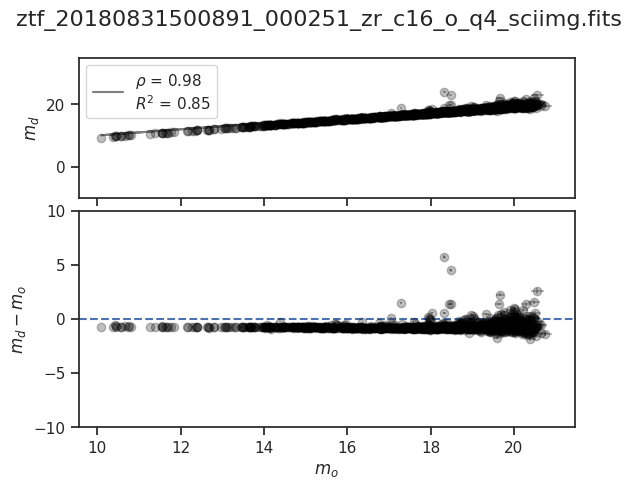

In [ ]:
def plot_mag(matched_cat, title=None):
    """ref_scat can be either original image scat or degraded image's scat depending on the setting used while running sgp."""

    fig=plt.figure()

    gs=GridSpec(5,1)

    ax1=fig.add_subplot(gs[0:2,0]) # First row, first column
    # ax2=fig.add_subplot(gs[0,1]) # First row, second column
    ax2=fig.add_subplot(gs[2:,0]) # Second row, span all columns

    # fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    deconv_mag, orig_mag = matched_cat['MAG_ISO_1'], matched_cat['MAG_ISO_2']
    deconv_magerr, orig_magerr = matched_cat['MAGERR_ISO_1'], matched_cat['MAGERR_ISO_2']
    mag_diff =  deconv_mag - orig_mag

    # Statistics
    pc, _ = pearsonr(orig_mag, deconv_mag)
    r2 = r2_score(orig_mag, deconv_mag)

    ax2.errorbar(orig_mag, mag_diff, fmt='o', c='black', xerr=orig_magerr, yerr=deconv_magerr+orig_magerr, alpha=0.25)
    ax1.errorbar(orig_mag, deconv_mag, fmt='o', c='black', xerr=orig_magerr, yerr=deconv_magerr, alpha=0.25)
    ax1.plot(orig_mag, orig_mag, c='gray', label=fr'$\rho$ = {np.round(pc, 2)}'+'\n'+fr'$R^2$ = {np.round(r2, 2)}')
    ax2.set_xlabel('$m_o$')
    ax2.axhline(y=0, linestyle='--')
    # ax2.axhline(y=-0.5, linestyle='--')
    # ax2.axhline(y=+0.5, linestyle='--')
    ax1.set_xlabel('$m_o$')
    ax2.set_ylabel('$m_d - m_o$')
    ax1.set_ylabel('$m_d$')
    # ax[2].set_xlim([])
    ax1.legend()
    ax1.set_ylim([-10, 35])
    ax2.set_ylim([-10, 10])
    # ax[0].set_yscale('log')
    # ax[0].set_xscale('log')
    # ax[2].set_yscale('log')
    # ax[2].set_xscale('log')
    # ax[1].set_xscale('log')
    # ax[1].set_yscale('log')
    # sns.kdeplot(ax=ax[1], y=deconv_mag, x=orig_mag, fill=True, shade=True)
    # ax[1].hexbin(orig_mag, deconv_mag, gridsize=50, cmap='Blues')

    # ax[0].get_shared_x_axes().join(ax[0], ax[1])
    # ax[0].get_shared_y_axes().join(ax[0], ax[1])

    s1, edges1, _ = binned_statistic(orig_mag, mag_diff, statistic=median_abs_deviation, bins=np.linspace(0, max(orig_mag), 40))
    try:
        best_deconv_mag = edges1[1:][np.where(s1 < 0.01)[0][-1]]
    except IndexError:
        best_deconv_mag = None

    print(f'The faintest source with reasonable flux conservation (scatter < 0.01 mag) has magnitude = {best_deconv_mag}')
    best_deconv_mag = edges1[1:][np.where(s1 < 0.1)[0][-1]]
    print(f'The faintest source with reasonable flux conservation (scatter < 0.1 mag) has magnitude = {best_deconv_mag}')
    best_deconv_mag = edges1[1:][np.where(s1 < 0.5)[0][-1]]
    print(f'The faintest source with reasonable flux conservation (scatter < 0.5 mag) has magnitude = {best_deconv_mag}')
    # ax2.plot(edges1[1:], s1, c='blue', linewidth=3)

    plt.show()

# Use only the symmetric match catalog for this comparison.
cat = pd.read_csv(os.path.join(DIRNAME, CROSSMATCHED_CATALOGS[1]))
plot_mag(cat, title=NAMES[i])

TODO: In this plot, note what order is md-mo compared to the mag errors themselves. If they are of similar order, preservation is perfect. But higher means slightly imperfect. Quantify that number.

The plot for `251_crossmatched_best_match_symmetric_1_and_2` looks very similar to the other three cases.

Preliminary thoughts: Revise the following: This implies that there are not a substantial fraction of original sources that have more than one match in the deconvolved. This also indicates the field is not heavily crowded, even without looking at the image.)

In [ ]:
from astropy.nddata import Cutout2D

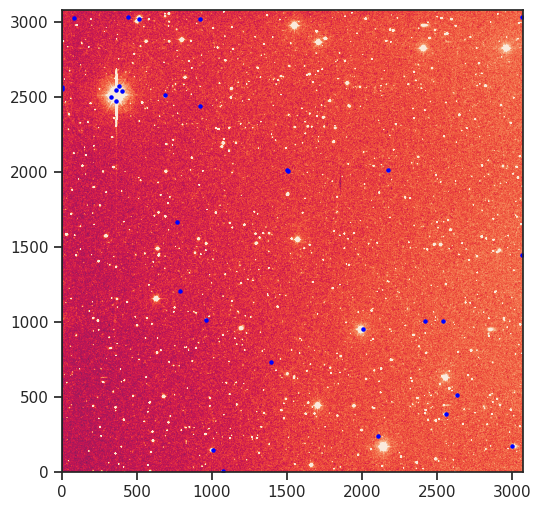

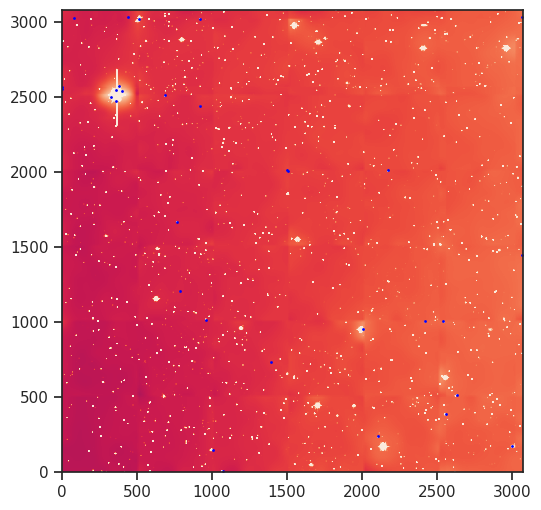

In [ ]:
def plot_unmatched_locations(unmatched_cat, name=None, fits_names=None):
    orig = fits.getdata(os.path.join(DIRNAME, fits_names[0]))
    deconv = fits.getdata(os.path.join(DIRNAME, fits_names[1]))
    norm1 = ImageNormalize(data=orig, interval=ZScaleInterval(contrast=0.99), stretch=LogStretch(a=1))

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    fig.subplots_adjust(hspace=0)
    ax.imshow(orig, origin='lower', norm=norm1)
    ax.scatter(unmatched_cat['X_IMAGE_DBL'], unmatched_cat['Y_IMAGE_DBL'], c='blue', s=5)
    ax.set_title(name)
    plt.savefig(os.path.join(DIRNAME, 'orig_img_orig_sources_marked_unmatched_'+fits_names[0]+'.png'))
    # plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    fig.subplots_adjust(hspace=0)
    ax.imshow(deconv, origin='lower', norm=norm1)
    ax.scatter(unmatched_cat['X_IMAGE_DBL'], unmatched_cat['Y_IMAGE_DBL'], c='blue', s=1)
    ax.set_title(name)
    plt.savefig(os.path.join(DIRNAME, 'deconv_img_orig_sources_marked_unmatched_'+fits_names[1]+'.png'))
    # plt.show()

    # Debug mode: Allows to compare deconvolved and original sources individually.
    # for row in unmatched_cat.iterrows():
    #     cutout = Cutout2D(deconv, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=40)
    #     fits.writeto(f'cutout_from_deconv_{row[1]["X_IMAGE_DBL"]}_{row[1]["Y_IMAGE_DBL"]}.fits', cutout.data, overwrite=True)
    #     cutout = Cutout2D(orig, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=40)
    #     fits.writeto(f'cutout_from_orig_{row[1]["X_IMAGE_DBL"]}_{row[1]["Y_IMAGE_DBL"]}.fits', cutout.data, overwrite=True)

cat = pd.read_csv(os.path.join(DIRNAME, CROSSMATCHED_CATALOGS_2_not_1))
plot_unmatched_locations(cat, fits_names=IMAGE_FITS_NAMES)

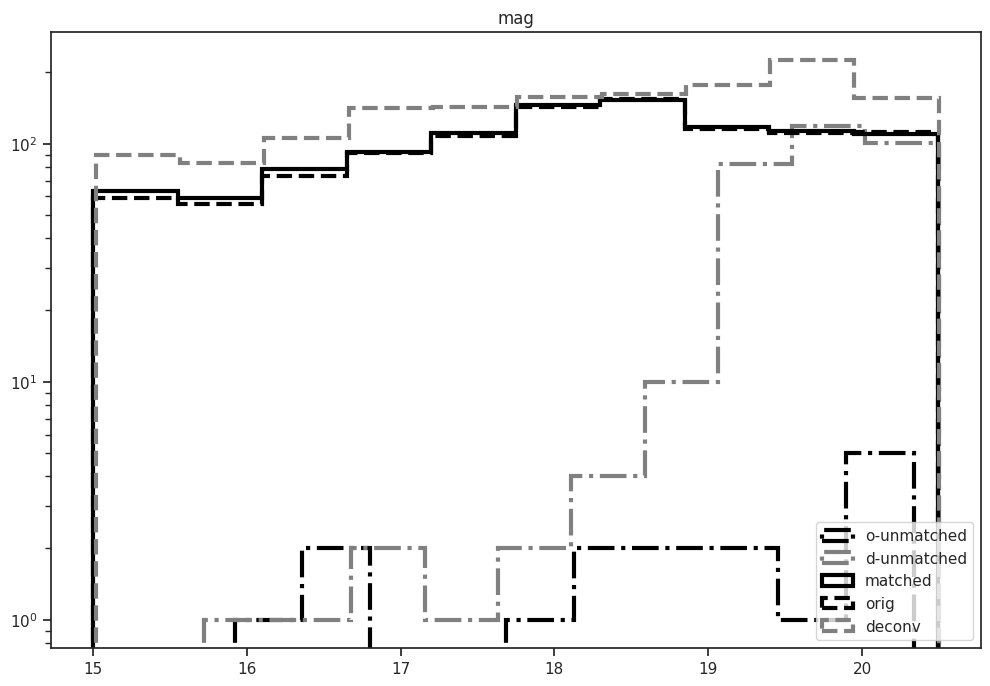

Median FWHM of all orig and deconv sources: 2.94, 1.3


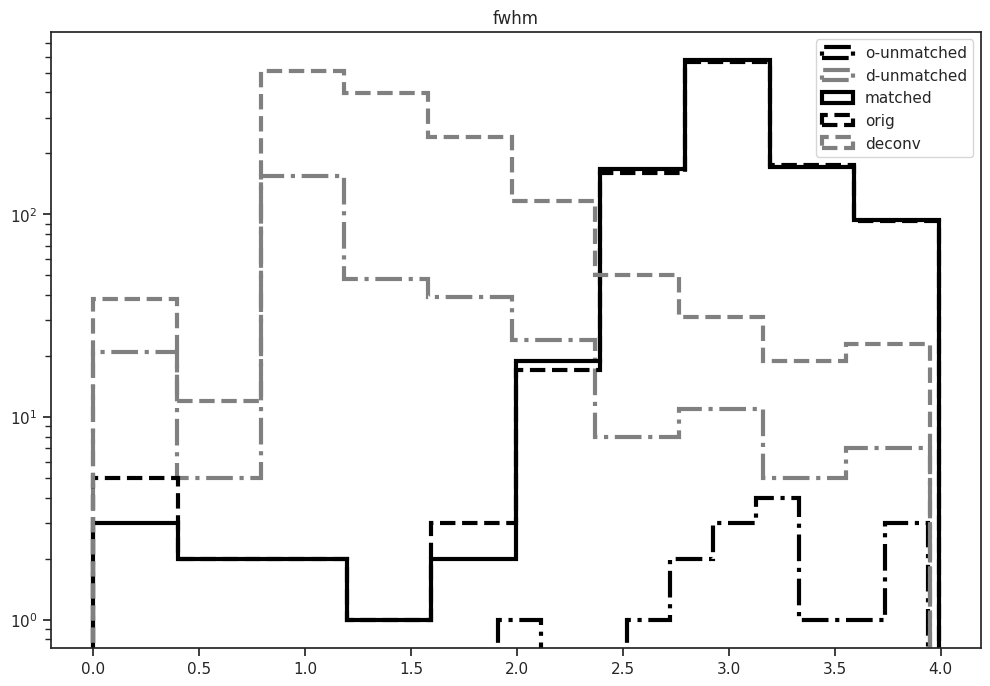

Median ellipticity of all orig and deconv sources: 0.075, 0.066


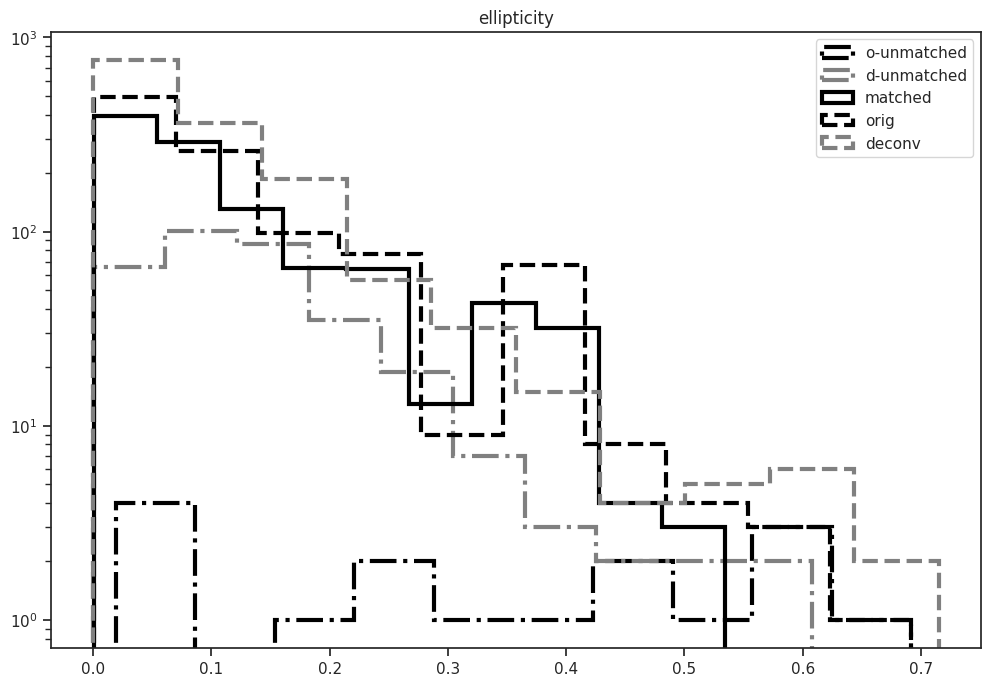

In [ ]:
def plot_prop(matched_cat, unmatched_ocat, unmatched_dcat, orig_cat, deconv_cat, prop='mag', log_yscale=False, loc='upper left', xlim=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    # For FWHM/ellipticity, only select point sources.
    # if prop == 'fwhm' or prop == 'ellipticity':
    #     matched_cat = matched_cat[matched_cat['CLASS_STAR_2'] > 0.75]
    #     unmatched_ocat = unmatched_ocat[unmatched_ocat['CLASS_STAR'] > 0.75]
    #     unmatched_dcat = unmatched_dcat[unmatched_dcat['CLASS_STAR'] > 0.75]
    #     orig_cat = orig_cat[orig_cat['CLASS_STAR'] > 0.75]
    #     deconv_cat = deconv_cat[deconv_cat['CLASS_STAR'] > 0.75]

    # Selection
    # 1. Magnitude cut
    matched_cat = matched_cat[(matched_cat['MAG_ISO_2'] >= 15) & (matched_cat['MAG_ISO_2'] <= 20.5)]
    unmatched_ocat = unmatched_ocat[(unmatched_ocat['MAG_ISO'] >= 15) & (unmatched_ocat['MAG_ISO'] <= 20.5)]
    unmatched_dcat = unmatched_dcat[(unmatched_dcat['MAG_ISO'] >= 15) & (unmatched_dcat['MAG_ISO'] <= 20.5)]
    orig_cat = orig_cat[(orig_cat['MAG_ISO'] >= 15) & (orig_cat['MAG_ISO'] <= 20.5)]
    deconv_cat = deconv_cat[(deconv_cat['MAG_ISO'] >= 15) & (deconv_cat['MAG_ISO'] <= 20.5)]

    # 2. FWHM cut
    matched_cat = matched_cat[(matched_cat['FWHM_IMAGE_2'] >= 0) & (matched_cat['FWHM_IMAGE_2'] <= 4)]
    unmatched_ocat = unmatched_ocat[(unmatched_ocat['FWHM_IMAGE'] >= 0) & (unmatched_ocat['FWHM_IMAGE'] <= 4)]
    unmatched_dcat = unmatched_dcat[(unmatched_dcat['FWHM_IMAGE'] >= 0) & (unmatched_dcat['FWHM_IMAGE'] <= 4)]
    orig_cat = orig_cat[(orig_cat['FWHM_IMAGE'] >= 0) & (orig_cat['FWHM_IMAGE'] <= 4)]
    deconv_cat = deconv_cat[(deconv_cat['FWHM_IMAGE'] >= 0) & (deconv_cat['FWHM_IMAGE'] <= 4)]

    if prop == 'mag':
        dmag = unmatched_dcat['MAG_ISO']
        # dmag = dmag[(dmag > dmag.quantile(0.01)) & (dmag < dmag.quantile(0.99))]
        ax.hist(unmatched_ocat['MAG_ISO'], histtype='step', label='o-unmatched', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(dmag, histtype='step', label='d-unmatched', linewidth=3, linestyle='dashdot', color='gray')
        ax.hist(matched_cat['MAG_ISO_2'], histtype='step', label='matched', linewidth=3, linestyle='solid', color='black')
        ax.hist(orig_cat['MAG_ISO'], histtype='step', label='orig', linewidth=3, linestyle='dashed', color='black')
        ax.hist(deconv_cat['MAG_ISO'], histtype='step', label='deconv', linewidth=3, linestyle='dashed', color='gray')
    elif prop == 'fwhm':
        dfwhm = unmatched_dcat['FWHM_IMAGE']
        deconv_fwhm = deconv_cat['FWHM_IMAGE']

        # Some filters
        # dfwhm = dfwhm[(dfwhm > dfwhm.quantile(0.03)) & (dfwhm < dfwhm.quantile(0.97))]
        # deconv_fwhm = deconv_fwhm[(deconv_fwhm > 0)]

        print(f'Median FWHM of all orig and deconv sources: {np.median(orig_cat["FWHM_IMAGE"])}, {np.median(deconv_fwhm)}')

        ax.hist(unmatched_ocat['FWHM_IMAGE'], histtype='step', label='o-unmatched', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(dfwhm, histtype='step', label='d-unmatched', linewidth=3, linestyle='dashdot', color='gray')
        ax.hist(matched_cat['FWHM_IMAGE_2'], histtype='step', label='matched', linewidth=3, linestyle='solid', color='black')
        ax.hist(orig_cat['FWHM_IMAGE'], histtype='step', label='orig', linewidth=3, linestyle='dashed', color='black')
        ax.hist(deconv_fwhm, histtype='step', label='deconv', linewidth=3, linestyle='dashed', color='gray')
    elif prop == 'ellipticity':
        dell = unmatched_dcat['ELLIPTICITY']
        # dell = dell[(dell > dell.quantile(0.03)) & (dell < dell.quantile(0.97))]

        print(f'Median ellipticity of all orig and deconv sources: {np.median(orig_cat["ELLIPTICITY"])}, {np.median(deconv_cat["ELLIPTICITY"])}')

        ax.hist(unmatched_ocat['ELLIPTICITY'], histtype='step', label='o-unmatched', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(dell, histtype='step', label='d-unmatched', linewidth=3, linestyle='dashdot', color='gray')
        ax.hist(matched_cat['ELLIPTICITY_2'], histtype='step', label='matched', linewidth=3, linestyle='solid', color='black')
        ax.hist(orig_cat['ELLIPTICITY'], histtype='step', label='orig', linewidth=3, linestyle='dashed', color='black')
        ax.hist(deconv_cat['ELLIPTICITY'], histtype='step', label='deconv', linewidth=3, linestyle='dashed', color='gray')
    if log_yscale:
        ax.set_yscale('log')
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.legend(loc=loc)
    ax.set_title(prop)
    plt.show()


catname = [CROSSMATCHED_CATALOGS_2_not_1, CROSSMATCHED_CATALOGS_1_not_2, CROSSMATCHED_CATALOGS[2], SOURCE_CATALOGS]
um_ocat = pd.read_csv(os.path.join(DIRNAME, catname[0]))
um_dcat = pd.read_csv(os.path.join(DIRNAME, catname[1]))
mcat = pd.read_csv(os.path.join(DIRNAME, catname[2]))
ocat = pd.read_csv(os.path.join(DIRNAME, catname[3][0]))
dcat = pd.read_csv(os.path.join(DIRNAME, catname[3][1]))
plot_prop(mcat, um_ocat, um_dcat, ocat, dcat, prop='mag', log_yscale=True, loc='lower right')
plot_prop(mcat, um_ocat, um_dcat, ocat, dcat, prop='fwhm', log_yscale=True, loc='upper right')
plot_prop(mcat, um_ocat, um_dcat, ocat, dcat, prop='ellipticity', log_yscale=True, loc='upper right')

Now doing the above plot for all three types of matched catalogs together

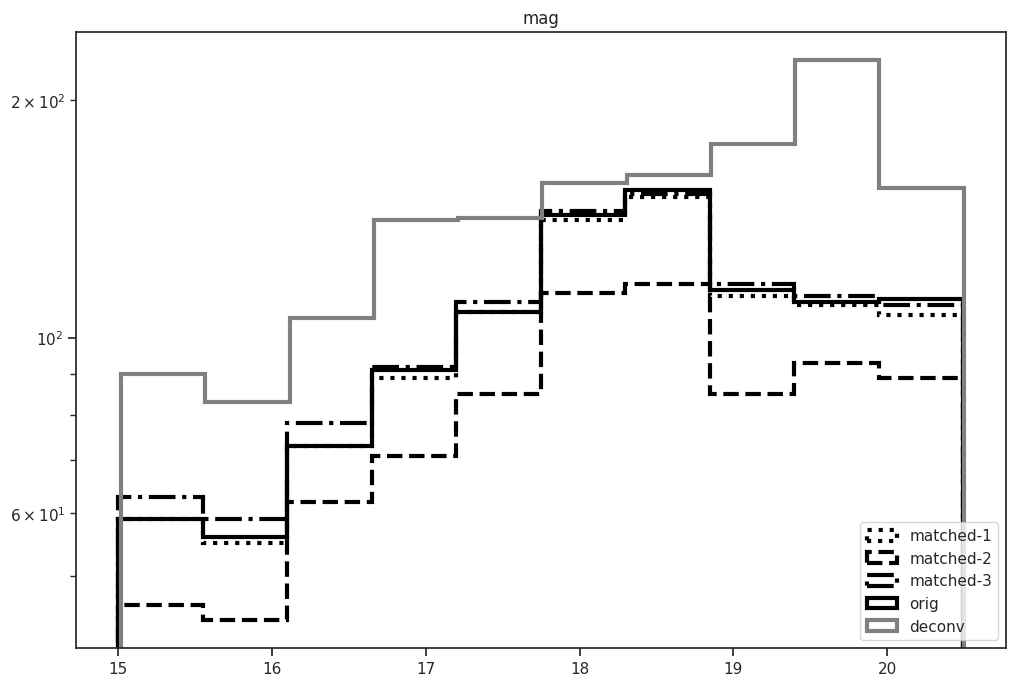

Median FWHM of all orig and deconv sources: 2.94, 1.3


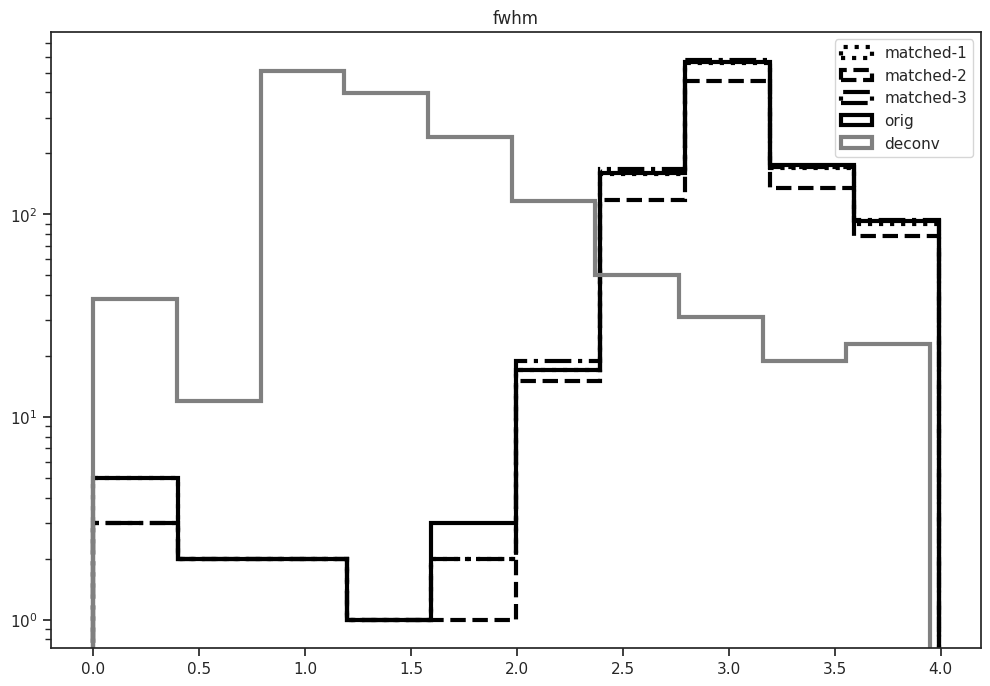

Median ellipticity of all orig and deconv sources: 0.075, 0.066


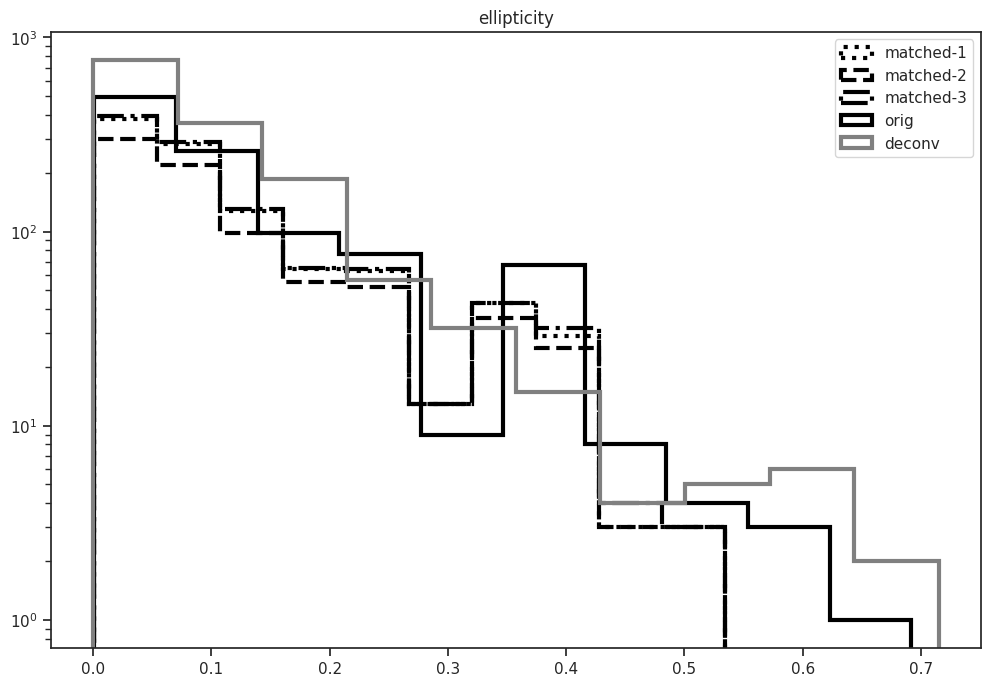

In [ ]:
def plot_prop(matched_cat1, matched_cat2, matched_cat3, orig_cat, deconv_cat, prop='mag', log_yscale=False, loc='upper left', xlim=None, CROSSMATCHED_CATALOGS_NAMES=CROSSMATCHED_CATALOGS_NAMES):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Selection
    # 1. Magnitude cut
    matched_cat1 = matched_cat1[(matched_cat1['MAG_ISO_2'] >= 15) & (matched_cat1['MAG_ISO_2'] <= 20.5)]
    matched_cat2 = matched_cat2[(matched_cat2['MAG_ISO_2'] >= 15) & (matched_cat2['MAG_ISO_2'] <= 20.5)]
    matched_cat3 = matched_cat3[(matched_cat3['MAG_ISO_2'] >= 15) & (matched_cat3['MAG_ISO_2'] <= 20.5)]
    orig_cat = orig_cat[(orig_cat['MAG_ISO'] >= 15) & (orig_cat['MAG_ISO'] <= 20.5)]
    deconv_cat = deconv_cat[(deconv_cat['MAG_ISO'] >= 15) & (deconv_cat['MAG_ISO'] <= 20.5)]

    # 2. FWHM cut
    matched_cat1 = matched_cat1[(matched_cat1['FWHM_IMAGE_2'] >= 0) & (matched_cat1['FWHM_IMAGE_2'] <= 4)]
    matched_cat2 = matched_cat2[(matched_cat2['FWHM_IMAGE_2'] >= 0) & (matched_cat2['FWHM_IMAGE_2'] <= 4)]
    matched_cat3 = matched_cat3[(matched_cat3['FWHM_IMAGE_2'] >= 0) & (matched_cat3['FWHM_IMAGE_2'] <= 4)]
    orig_cat = orig_cat[(orig_cat['FWHM_IMAGE'] >= 0) & (orig_cat['FWHM_IMAGE'] <= 4)]
    deconv_cat = deconv_cat[(deconv_cat['FWHM_IMAGE'] >= 0) & (deconv_cat['FWHM_IMAGE'] <= 4)]

    if prop == 'mag':
        ax.hist(matched_cat1['MAG_ISO_2'], histtype='step', label='matched-1', linewidth=3, linestyle='dotted', color='black')
        ax.hist(matched_cat2['MAG_ISO_2'], histtype='step', label='matched-2', linewidth=3, linestyle='dashed', color='black')
        ax.hist(matched_cat3['MAG_ISO_2'], histtype='step', label='matched-3', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(orig_cat['MAG_ISO'], histtype='step', label='orig', linewidth=3, linestyle='solid', color='black')
        ax.hist(deconv_cat['MAG_ISO'], histtype='step', label='deconv', linewidth=3, linestyle='solid', color='gray')
    elif prop == 'fwhm':
        print(f'Median FWHM of all orig and deconv sources: {np.median(orig_cat["FWHM_IMAGE"])}, {np.median(deconv_cat["FWHM_IMAGE"])}')
        ax.hist(matched_cat1['FWHM_IMAGE_2'], histtype='step', label='matched-1', linewidth=3, linestyle='dotted', color='black')
        ax.hist(matched_cat2['FWHM_IMAGE_2'], histtype='step', label='matched-2', linewidth=3, linestyle='dashed', color='black')
        ax.hist(matched_cat3['FWHM_IMAGE_2'], histtype='step', label='matched-3', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(orig_cat['FWHM_IMAGE'], histtype='step', label='orig', linewidth=3, linestyle='solid', color='black')
        ax.hist(deconv_cat['FWHM_IMAGE'], histtype='step', label='deconv', linewidth=3, linestyle='solid', color='gray')
    elif prop == 'ellipticity':
        print(f'Median ellipticity of all orig and deconv sources: {np.median(orig_cat["ELLIPTICITY"])}, {np.median(deconv_cat["ELLIPTICITY"])}')
        ax.hist(matched_cat1['ELLIPTICITY_2'], histtype='step', label='matched-1', linewidth=3, linestyle='dotted', color='black')
        ax.hist(matched_cat2['ELLIPTICITY_2'], histtype='step', label='matched-2', linewidth=3, linestyle='dashed', color='black')
        ax.hist(matched_cat3['ELLIPTICITY_2'], histtype='step', label='matched-3', linewidth=3, linestyle='dashdot', color='black')
        ax.hist(orig_cat['ELLIPTICITY'], histtype='step', label='orig', linewidth=3, linestyle='solid', color='black')
        ax.hist(deconv_cat['ELLIPTICITY'], histtype='step', label='deconv', linewidth=3, linestyle='solid', color='gray')
    if log_yscale:
        ax.set_yscale('log')
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.legend(loc=loc)
    ax.set_title(prop)
    plt.show()

catname = CROSSMATCHED_CATALOGS
mcat1 = pd.read_csv(os.path.join(DIRNAME, catname[0]))
mcat2 = pd.read_csv(os.path.join(DIRNAME, catname[1]))
mcat3 = pd.read_csv(os.path.join(DIRNAME, catname[2]))
# mcat4 is all matches, but that is not used for the plot here.
mcat4 = pd.read_csv(os.path.join(DIRNAME, catname[3]))
plot_prop(mcat1, mcat2, mcat3, ocat, dcat, prop='mag', log_yscale=True, loc='lower right')
plot_prop(mcat1, mcat2, mcat3, ocat, dcat, prop='fwhm', log_yscale=True, loc='upper right')
plot_prop(mcat1, mcat2, mcat3, ocat, dcat, prop='ellipticity', log_yscale=True, loc='upper right')

Now, magnitudes fainter than 20.5 in the deconvolved can be interesting. In the plot before the above plot, deconvolved magnitudes fainter than 20.5 are not included. Below, we plot a histogram for such magnitudes.

In [ ]:
um_dcat.shape

(1738, 45)

Text(0, 0.5, 'Counts')

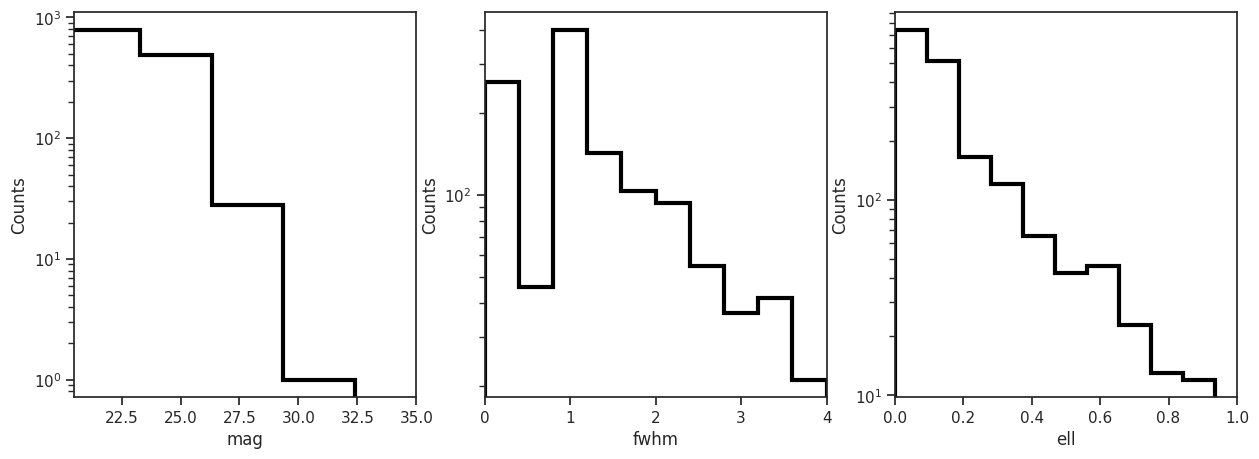

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(um_dcat['MAG_ISO'], bins=30, histtype='step', linewidth=3, color='black')
ax[0].set_yscale('log')
ax[0].set_xlim([20.5, 35])
ax[0].set_xlabel('mag')
ax[0].set_ylabel('Counts')

_dfwhms = um_dcat['FWHM_IMAGE']
_dfwhms = _dfwhms[(_dfwhms >= 0) & (_dfwhms <= 4)]
ax[1].hist(_dfwhms, bins=10, histtype='step', linewidth=3, color='black')
ax[1].set_yscale('log')
ax[1].set_xlabel('fwhm')
ax[1].set_xlim([0, 4])
ax[1].set_ylabel('Counts')

ax[2].hist(um_dcat['ELLIPTICITY'], bins=10, histtype='step', linewidth=3, color='black')
ax[2].set_yscale('log')
ax[2].set_xlabel('ell')
ax[2].set_xlim([0, 1])
ax[2].set_ylabel('Counts')

Some terminology (notation used: deconvolved is the first table and original is the second table):

- `mcat3` is many-1.
- `mcat1` is 1-many.
- `mcat2` is a symmetric match.

For each symmetric match, we need to see two things:
1. Whether that symmetric match is the only possible match with the corresponding deconv source. (Simply looking at the 1-1 table won't help).
2. Whether that symmetric match is one of the matches with multiple deconv sources. (many-1 helps here).

What this means is that the symmetric match table from the notebook (mcat2) is not really a 1-1 match we are looking for since it includes both cases. Our definition of 1-1 here is that the orig source should have only one deconv matched source, whereas in the symmetric match table from the notebook, that orig source may also have multiple deconv sources, but only the best one is included in the symmetric match table. We should yield mcat2_modified, which will only contain case 1 from above and will have fewer rows than mcat2.

As we will see later in the notebook, `mcat2` (symmetric match) is a subset of `mcat3` (best match for each deconv source). Hence, each row in `mcat2` is contained in `mcat3`.

Thus, as I said above, to find the true no. of sources in the original that are split into two, we need to eliminate rows from `mcat3` that are present in `mcat2_modified` instead of `mcat2`.

In the below cell, we calculate `mcat2_modified`, and we will need both `mcat2` and `mcat3` for that.

In [ ]:
mcat2_modified = []
mcat2_modified_2 = []
for row in mcat2.itertuples():
    mcat3_subset = mcat3[(mcat3['X_IMAGE_DBL_2'] == row.X_IMAGE_DBL_2) & (mcat3['Y_IMAGE_DBL_2'] == row.Y_IMAGE_DBL_2)]
    assert len(mcat3_subset) > 0  # Because each row in mcat2 must be present in mcat3. (Proved later in the notebook).
    if len(mcat3_subset) == 1:  # This original source has exactly one match in the deconvolved.
        mcat2_modified.append(row)
    else:  # This original source has a match in the deconvolved, which is just one of the multiple matches to this original. But this match will anyways be the best one since it was included in mcat2.
        mcat2_modified_2.append(row)

mcat2_modified = pd.DataFrame(mcat2_modified)
mcat2_modified_2 = pd.DataFrame(mcat2_modified_2)
mcat2_modified.shape, mcat2_modified_2.shape, mcat2.shape

((862, 92), (289, 92), (1151, 91))

Obviously, since we are claiming (which is proved later in the notebook, so see there for details) that `mcat2` is a subset of `mcat3`, `mcat2_modified` and `mcat2_modified_2` must also be a subset of `mcat3`, since `mcat2_modified` and `mcat2_modified_2` are subsets of `mcat2`.

This is proved in the below three cells.

In [ ]:
len(mcat2.merge(mcat3)), len(mcat2)

(1151, 1151)

In [ ]:
len(mcat2_modified.merge(mcat3)), len(mcat2_modified)

(862, 862)

In [ ]:
len(mcat2_modified_2.merge(mcat3)), len(mcat2_modified_2)

(289, 289)

While the above approach can be used, a more straightforward and easy way to do that is to look at the `GroupID` and `GroupSize` columns of the asymmetric match tables. Below we ensure the above implementation matches with the implementation using the `GroupID` column.

See [this page](https://www.star.bris.ac.uk/~mbt/topcat/sun253/matchRowSelect.html) for more details.

In [ ]:
mcat3_groupid_sorted = mcat3.sort_values(by='GroupID')

# If a row has NaN in the GroupID column, means it is a unique match.
assert len(mcat3_groupid_sorted[mcat3_groupid_sorted['GroupID'].isna()]) == len(mcat2_modified)

One aside point: ideally, there must be some correlation between the FWHM and CLASS_STAR. Lower FWHMs must correspond to star-like profiles (CLASS_STAR close to 1).

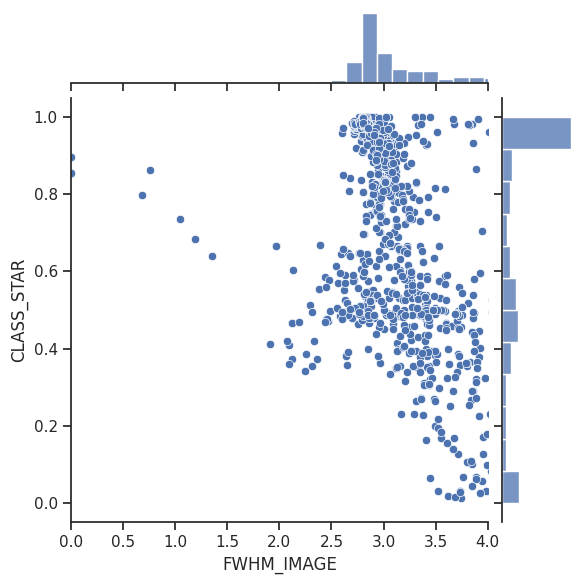

In [ ]:
sns.jointplot(x=ocat['FWHM_IMAGE'], y=ocat['CLASS_STAR'], xlim=[0, 4])

The plot above does show that lower FWHMs have a higher CLASS_STAR. Any source with $\textrm{FWHM} \gtrsim 4$ have a CLASS_STAR ~ 0.

Two important points:
1. There is a sharp increase in the CLASS_STAR in going from FWHM ~ 4 to FWHM ~ 3.
2. Majority of the sources with $0 \lesssim \textrm{FWHM} \lesssim 2.5$ have a CLASS_STAR between 0.35 and 0.5, which means the classifier is confused but slightly leans towards classifying them as non-star-like sources. This means some other properties of such sources is affecting the CLASS_STAR.

Recall that FWHM_IMAGE means the units are in pix and not arcsec.

How many of the sources in orig but not in deconv are point-like sources (based on `CLASS_STAR`)?

In [ ]:
um_ocat.shape

(31, 45)

Text(0, 0.5, 'Counts')

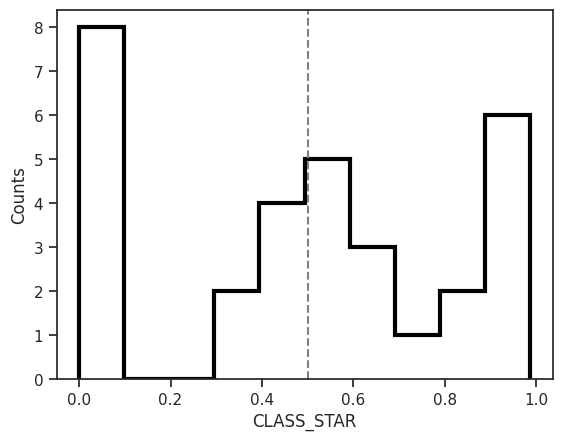

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(um_ocat['CLASS_STAR'], linewidth=3, color='black', histtype='step')
ax.axvline(x=0.5, c='gray', linestyle='--')
ax.set_xlabel('CLASS_STAR')
ax.set_ylabel('Counts')

In [ ]:
um_ocat['FLAGS'].value_counts()

24.0    18
0.0      9
16.0     2
18.0     1
26.0     1
Name: FLAGS, dtype: int64

Majority of the unmatched sources have innocuous flags  (i.e., `FLAGS = 0`).

---



Text(0, 0.5, 'Counts')

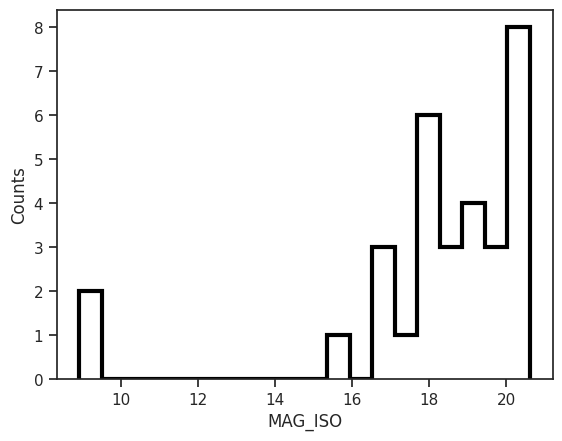

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(um_ocat['MAG_ISO'], linewidth=3, color='black', histtype='step', bins=20)
ax.set_xlabel('MAG_ISO')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

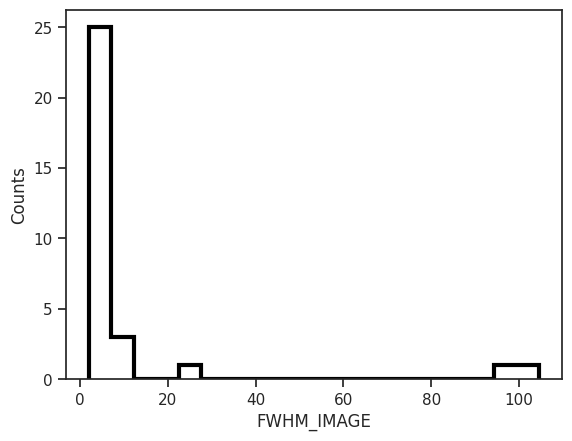

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(um_ocat['FWHM_IMAGE'], linewidth=3, color='black', histtype='step', bins=20)
ax.set_xlabel('FWHM_IMAGE')
ax.set_ylabel('Counts')

How many of the sources present in deconvolved but not in original are fainter than 20.5 mag and how many are star-like?

(20.5, 30.0)

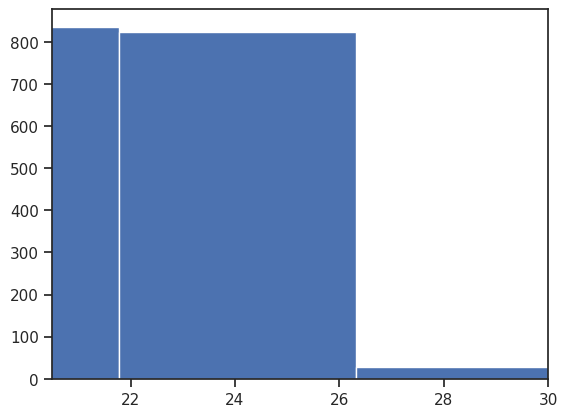

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(um_dcat['MAG_ISO'], bins=20);
ax.set_xlim([20.5, 30])

Text(0, 0.5, 'Counts')

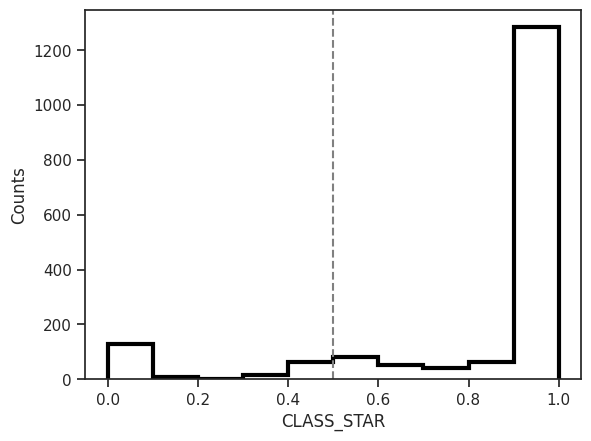

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(um_dcat['CLASS_STAR'], linewidth=3, color='black', histtype='step')
ax.axvline(x=0.5, c='gray', linestyle='--')
ax.set_xlabel('CLASS_STAR')
ax.set_ylabel('Counts')

`CLASS_STAR` on the deconvolved will be slightly biased towards point sources because of two reasons:

1. Deconvolution makes the sources more compact, thus increasing the chances to be classified as stellar.
2. The `SEEING_FWHM` parameter used as input to Sextractor's classifier is kept the same for both original and deconvolved. For original, it will be accurate, but for deconvolved, this seeing input is an overestimation.

We now also look at the statistics of the unmatched sources (present in orig but not in deconv)

In [ ]:
um_ocat.head(3)

,col1,Unnamed: 0,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,BACKGROUND,ISOAREA_IMAGE,ISOAREAF_IMAGE,...,AWIN_WORLD,BWIN_WORLD,THETAWIN_WORLD,MU_THRESHOLD,FLAGS,FWHM_IMAGE,ELONGATION,ELLIPTICITY,CLASS_STAR,SUBDIV_NUMBER
0,69,69,2.0,509.6591,37.54681,19.3551,0.080,603.5739,11.0,13.0,...,1.026874,0.882152,19.73,22.6431,24.0,3.26,1.184,0.155,0.575,2.0
1,95,95,28.0,1911.7810,63.36674,17.9197,0.036,604.0555,32.0,37.0,...,1.572195,1.386980,-87.29,22.6545,24.0,7.53,1.357,0.263,0.476,2.0
2,156,156,24.0,12048.8000,88.59757,15.9209,0.008,609.6167,51.0,54.0,...,0.913745,0.900107,89.39,22.6454,0.0,2.85,1.034,0.032,0.986,4.0


Now moving ahead...

In [ ]:
ocat.shape, dcat.shape, mcat3.shape, um_ocat.shape, um_dcat.shape

((1471, 45), (3215, 45), (1477, 93), (31, 45), (1738, 45))

In [ ]:
print(CROSSMATCHED_CATALOGS_NAMES)
mcat1.shape, mcat2.shape, mcat3.shape

['best_match_for_each_table2_row_1_and_2', 'best_match_symmetric_1_and_2', 'best_match_for_each_table1_row_1_and_2', 'all_matches_1_and_2']


((1440, 93), (1151, 91), (1477, 93))

In [ ]:
ocat.shape, mcat1.shape, mcat2.shape, mcat3.shape

((1471, 45), (1440, 93), (1151, 91), (1477, 93))

In [ ]:
len(mcat2.merge(mcat1)), len(mcat2)

(1113, 1151)

In [ ]:
len(mcat2.merge(mcat3)), len(mcat2)

(1151, 1151)

The fact that `len(mcat2)` does not equal `len(mcat3)` implies that there are some sources in the original image that have more than one counterpart in the deconvolved within the threshold allowed during crossmatching. The length of `mcat2` being smaller than `mcat3` doesn't mean anything bad, it's just telling us how typical is to find multiple deconvolved sources for a single original source in this particular image. `mcat2` is a subset of `mcat3`, as seen from the above cells. But note that `mcat2` is not necessarily a subset of `mcat1`, where a subset means all columns of a given row in one catalog is the same with all columns of some row in the other catalog. (If `mcat2` were a subset of `mcat1`, the following should have hold: `len(mcat2.merge(mcat1)) == len(mcat2)`, which does not hold true as seen in the above cell. See [here](https://stackoverflow.com/a/49531052)).

In `mcat3`, we can search for the same original source and find different deconvolved sources to it, if any. These cases could comprise sources that were blended in the original image (so a single source) but detected as multiple in the deconvolved. If it's a crowded field, such matches can also arise simply because of close proximity to other sources which are not related. (If you think `mcat3` must be `mcat1` instead, try to make a rough diagram on paper of two catalogs and visualize a bit and you will see why `mcat3` and not `mcat1` is used here).

`mcat2` and `mcat3` may not contain all rows from the original image's catalog because a row from the original image's catalog will only be included if there is a match in the deconvolved. Also, we can compare the no. of rows in `ocat` and `mcat1`. The difference in their no. of rows will give the no. of sources in the original that did not have any match in the deconvolved, which should be exactly the no. of rows in `um_ocat`.

Similarly, the difference in the no. of rows of `dcat` and `mcat3` will give the no. of sources present in the deconvolved with no match in the original.

The difference in the no. of rows in the original image's catalog and the no. of rows in `mcat2` will comprise of these two types of sources: (a) original sources not having any matched source in the deconvolved, and (b) original sources that have a match with the deconvolved, but the closest match to that deconvolved is not this original source but some other source. (In (b), we are sure that the original source will have some match in the deconvolved since (a) has already handled the case where there was no match in the deconvolved).

In [ ]:
dcat.shape, mcat3.shape, um_dcat.shape

((3215, 45), (1477, 93), (1738, 45))

In [ ]:
ocat.shape, mcat1.shape, um_ocat.shape

((1471, 45), (1440, 93), (31, 45))

In [ ]:
ocat.shape, dcat.shape, mcat2.shape

((1471, 45), (3215, 45), (1151, 91))

Fainter (higher magnitude) sources have a bigger size in the figure.


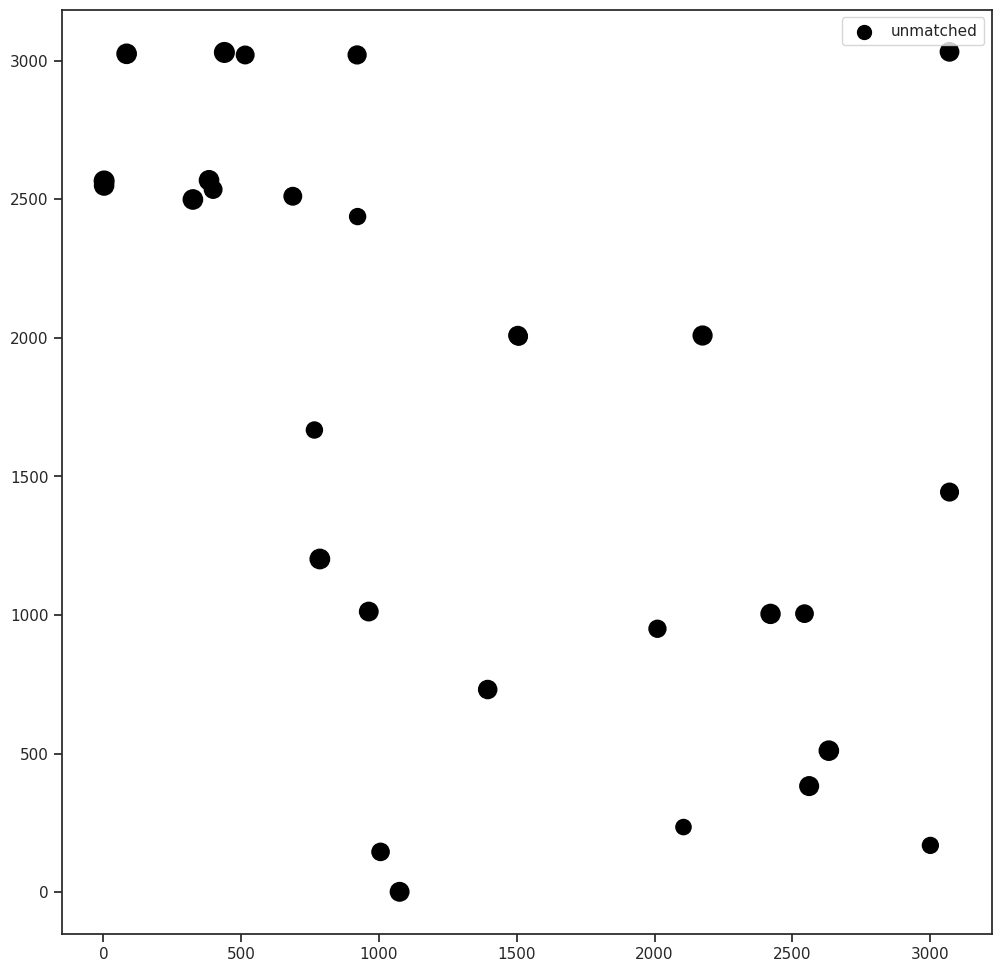

In [ ]:
def minmax_normalize(arr):  # arr must be a 1D array.
    return (arr - arr.min()) / (arr.max() - arr.min())

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# y = um_dcat[(um_dcat['MAG_ISO'] >= 15) & (um_dcat['MAG_ISO'] <= 20.5)]['MAG_ISO']
# x = um_ocat[(um_ocat['MAG_ISO'] >= 15) & (um_ocat['MAG_ISO'] <= 20.5)]['MAG_ISO']
# ax.plot(x, marker='o', linestyle='none');

ax.scatter(um_ocat['X_IMAGE_DBL'], um_ocat['Y_IMAGE_DBL'], c='black', label='unmatched', s=minmax_normalize(um_ocat['MAG_ISO'])*200)
# ax.scatter(mcat3['X_IMAGE_DBL_2'], mcat3['Y_IMAGE_DBL_2'], c='black', label='matched', marker='x', s=minmax_normalize(mcat3['MAG_ISO_2'])*200)
ax.legend()
print('Fainter (higher magnitude) sources have a bigger size in the figure.')

The above figure shows that unmatched sources have some preference towards a particular region of the image (middle-top right or middle-bottom right or left-middle). This is an important aspect since the deconvolution was performed on subdivisions rather than the entire image. No preference for matched sources is a good sign suggesting that the matches are not biased towards any subdivision.

Checking the distribution of the separation for the matched sources.

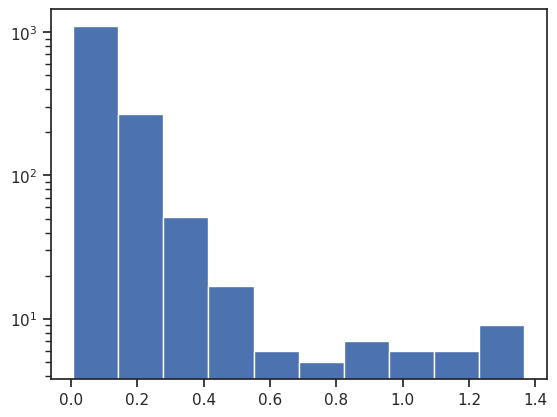

In [ ]:
fig, ax = plt.subplots()
ax.hist(mcat3['Separation']); ax.set_yscale('log')

Most separations are within one pixel, which is good. Note the upper limit set during crossmatching was 1.383 pix.

In [ ]:
print(um_ocat['FLAGS'].value_counts())
print(um_dcat['FLAGS'].value_counts())

24.0    18
0.0      9
16.0     2
18.0     1
26.0     1
Name: FLAGS, dtype: int64
0.0     1455
3.0       91
24.0      76
16.0      45
1.0       28
2.0       15
19.0      10
7.0        8
26.0       4
17.0       3
18.0       1
28.0       1
30.0       1
Name: FLAGS, dtype: int64


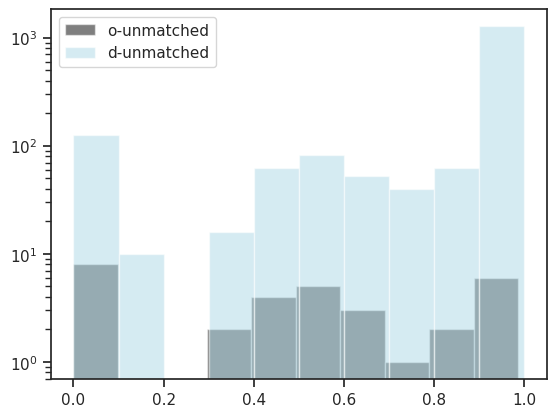

In [ ]:
plt.hist(um_ocat['CLASS_STAR'], color='black', alpha=0.5, label='o-unmatched')
plt.hist(um_dcat['CLASS_STAR'], color='lightblue', alpha=0.5, label='d-unmatched');
plt.legend()
plt.yscale('log')

## Cutouts of a few unmatched sources for visual inspection

Showing unmatched sources (present in original but not in deconvolved) and the corresponding patch in the deconvolved image. Note that the deconvolved sources, although can be seen visually, were not detected by SExtractor


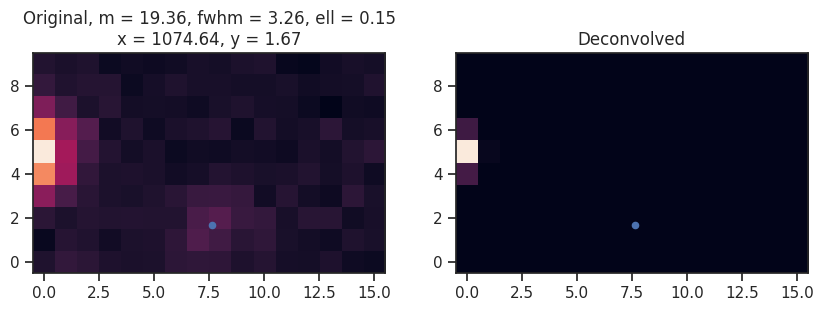

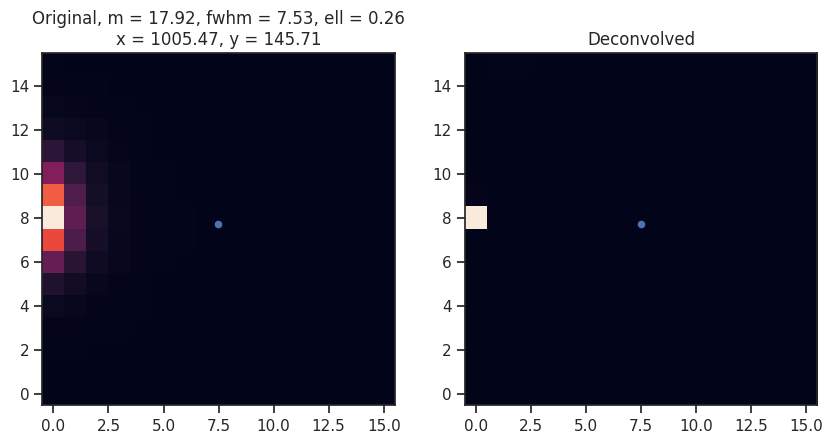

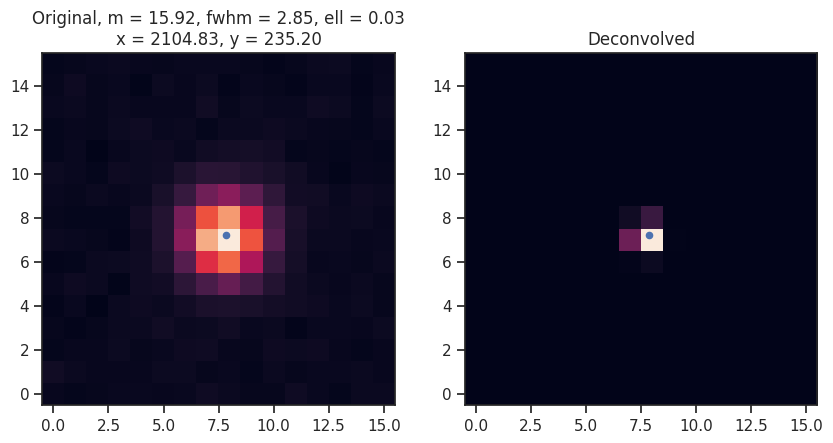

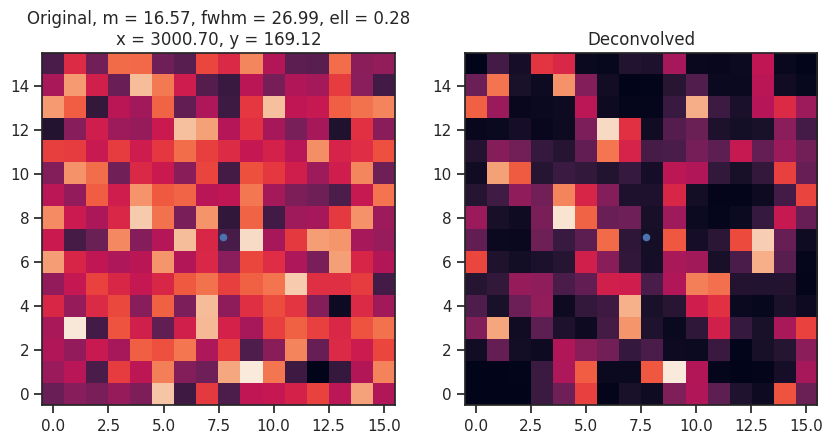

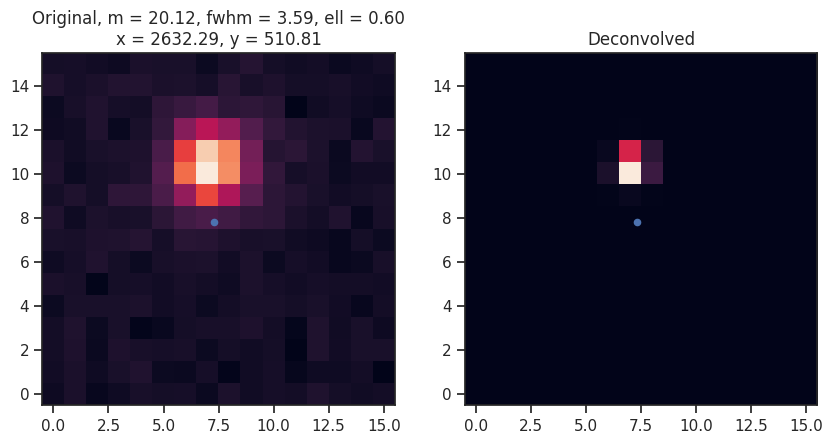

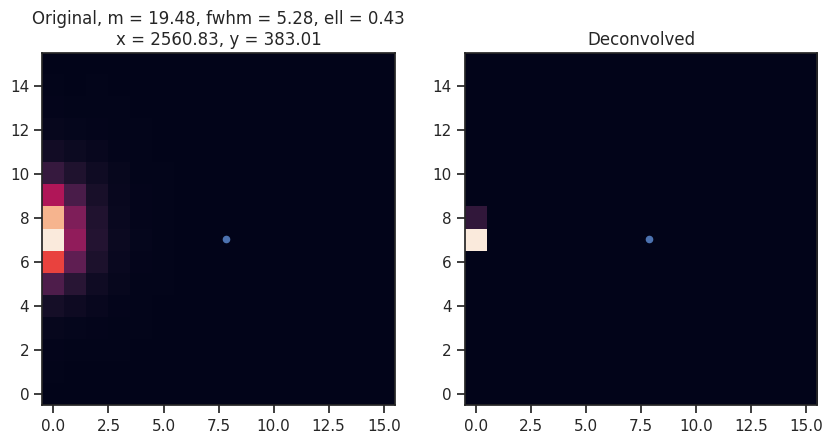

In [ ]:
from astropy.wcs import WCS
data_path_sciimg = os.path.join(DIRNAME, IMAGE_FITS_NAMES[0])
hdul = fits.open(data_path_sciimg)
wcs = WCS(hdul[0].header)

def plot_unmatched_locations(unmatched_cat, name=None, fits_name=None):
    orig = fits.getdata(os.path.join(DIRNAME, fits_name[0]))
    deconv = fits.getdata(os.path.join(DIRNAME, fits_name[1]))

    # Debug mode: Allows to compare deconvolved and original sources individually.
    for row in unmatched_cat.iterrows():
        dcutout = Cutout2D(deconv, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=16)
        ocutout = Cutout2D(orig, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=16, wcs=wcs)

        _x, _y = ocutout.to_cutout_position((row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']))

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(ocutout.data, origin='lower')
        ax[0].set_title(f'Original, m = {row[1]["MAG_ISO"]:.2f}, fwhm = {row[1]["FWHM_IMAGE"]:.2f}, ell = {row[1]["ELLIPTICITY"]:.2f}\nx = {row[1]["X_IMAGE_DBL"]:.2f}, y = {row[1]["Y_IMAGE_DBL"]:.2f}')
        ax[1].imshow(dcutout.data, origin='lower')
        ax[1].set_title(f'Deconvolved')
        # Mark coordinates.
        ax[0].scatter([_x], [_y], s=20)
        ax[1].scatter([_x], [_y], s=20)
        # ax[0].scatter([20], [20], s=20)
        # ax[1].scatter([20], [20], s=20)
        plt.show()

        if row[0] == 5:
            break

print('Showing unmatched sources (present in original but not in deconvolved) and the corresponding patch in the deconvolved image. Note that the deconvolved sources, although can be seen visually, were not detected by SExtractor')
cat = pd.read_csv(os.path.join(DIRNAME, CROSSMATCHED_CATALOGS_2_not_1))
plot_unmatched_locations(cat, fits_name=IMAGE_FITS_NAMES)

Recall that the marked positions in the deconvolved does not indicate the position of the detected source in the deconvolved. Instead, these deconvolved sources were not (somehow) detected by SExtractor and thus coul not match with the original source marked with the blue dot in the original image. The blue dot in the deconvolved marks the same location as in the blue dot in the original image to help visualize.

In [ ]:
um_ocat.shape, um_dcat.shape, mcat3.shape, ocat.shape, dcat.shape

((31, 45), (1738, 45), (1477, 93), (1471, 45), (3215, 45))

Now see how many unmatched sources (present in orig but not in deconvolved) are actually fainter than 20.5 or brighter than 15 mag?

In [ ]:
um_ocat_veryfaint_orig_sources = um_ocat[um_ocat['MAG_ISO'] > 20.5]
um_ocat_verybright_orig_sources = um_ocat[um_ocat['MAG_ISO'] < 15]
um_ocat_veryfaint_orig_sources.shape, um_ocat_verybright_orig_sources.shape, um_ocat.shape

((2, 45), (2, 45), (31, 45))

How many unmatched sources (present in orig but not in deconvolved) are plausible in terms of FWHM (plausible means $0 \leq \textrm{FWHM} \leq 4$)

In [ ]:
um_ocat_fwhm_plausible_sources = um_ocat[(um_ocat['FWHM_IMAGE'] >= 0) & (um_ocat['FWHM_IMAGE'] <= 4)]
um_ocat_fwhm_plausible_sources.shape

(18, 45)

Out of these plausible unmatches in terms of FWHM, how many are faint and how many are bright?

In [ ]:
um_ocat_fwhm_plausible_sources_faint = um_ocat_fwhm_plausible_sources[um_ocat_fwhm_plausible_sources['MAG_ISO'] > 20.5]
um_ocat_fwhm_plausible_sources_bright = um_ocat_fwhm_plausible_sources[um_ocat_fwhm_plausible_sources['MAG_ISO'] < 15]

um_ocat_fwhm_plausible_sources_faint.shape, um_ocat_fwhm_plausible_sources_bright.shape

((2, 45), (0, 45))

Finally, in terms of magnitude and FWHM, how many plausible unmatches are present?

In [ ]:
plausible_unmatches = um_ocat[(um_ocat['MAG_ISO'] >= 15) & (um_ocat['MAG_ISO'] <= 20.5) & ((um_ocat['FWHM_IMAGE'] >= 0) & (um_ocat['FWHM_IMAGE'] <= 4))]
plausible_unmatches['FLAGS'].value_counts()

24.0    9
0.0     6
16.0    1
Name: FLAGS, dtype: int64

In [ ]:
plausible_unmatches.shape

(16, 45)

We can also see how many of these plausible unmatches (in terms of magnitude and FWHM) are highly elliptic sources since highly elliptic sources are less of a concern for unmatches.

In [ ]:
plausible_unmatches_high_ell = plausible_unmatches[plausible_unmatches['ELLIPTICITY'] > 0.5]
plausible_unmatches_low_ell = plausible_unmatches[plausible_unmatches['ELLIPTICITY'] < 0.5]
plausible_unmatches_high_ell.shape, plausible_unmatches_low_ell.shape

((5, 45), (11, 45))

In [ ]:
plausible_unmatches_low_ell['FLAGS']

0     24.0
2      0.0
9      0.0
12    24.0
13     0.0
17     0.0
21     0.0
25    24.0
27    24.0
28     0.0
30    24.0
Name: FLAGS, dtype: float64

First, visualize a few final plausible unmatched sources: with

1. $0 \leq \textrm{FWHM} \leq 4$
2. $\textrm{ELLIPTICITY} < 0.5$
3. $15 \leq \textrm{MAGNITUDE_ISO} \leq 20.5$

Same as above visualisation of sources, but only with plausible unmatched sources (after the three cuts above).


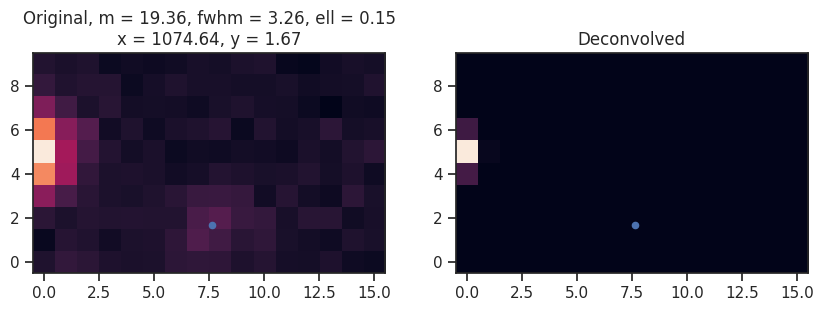

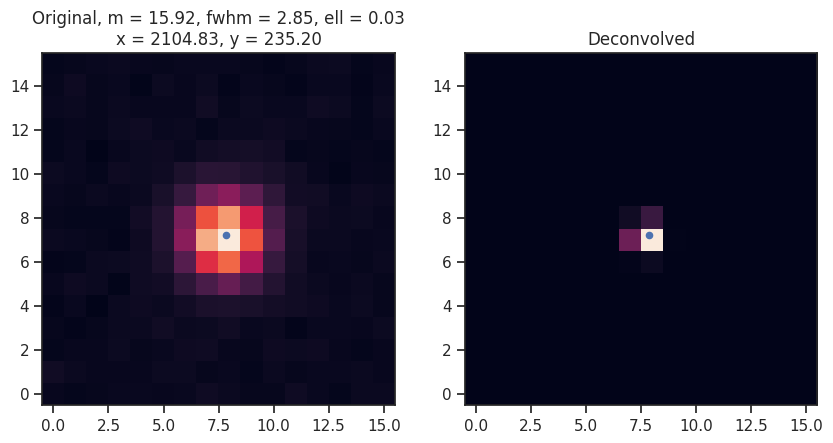

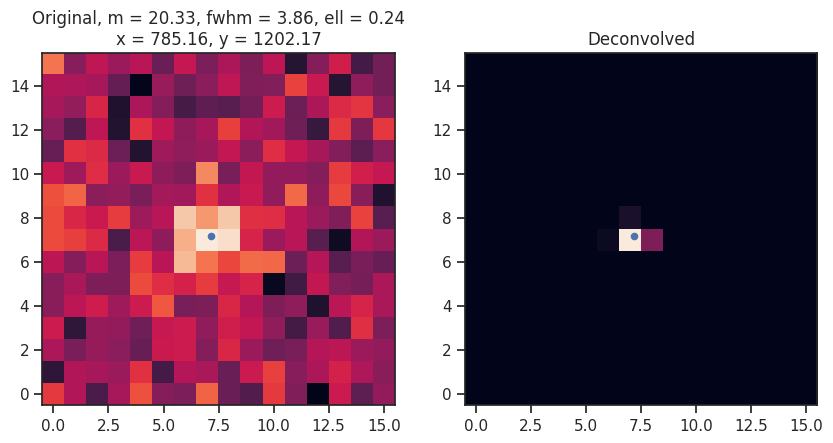

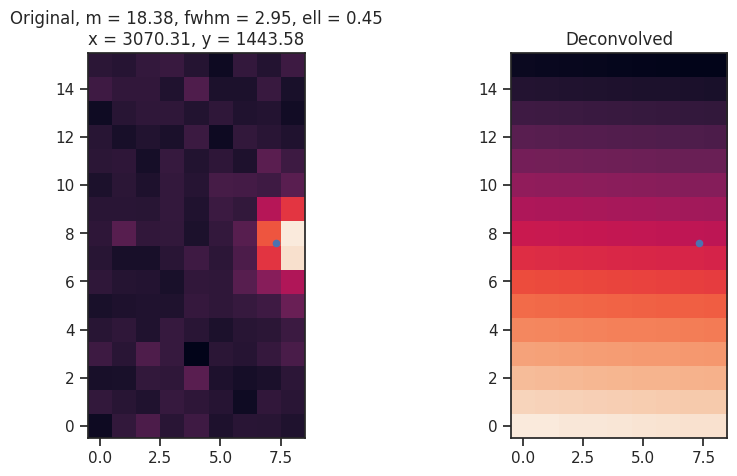

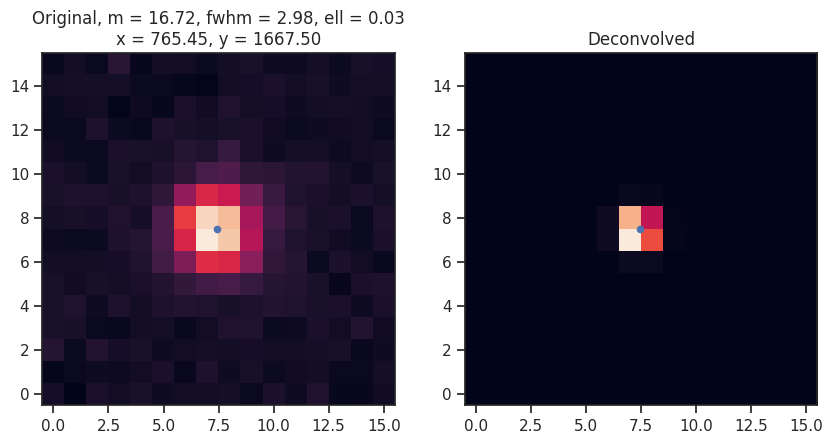

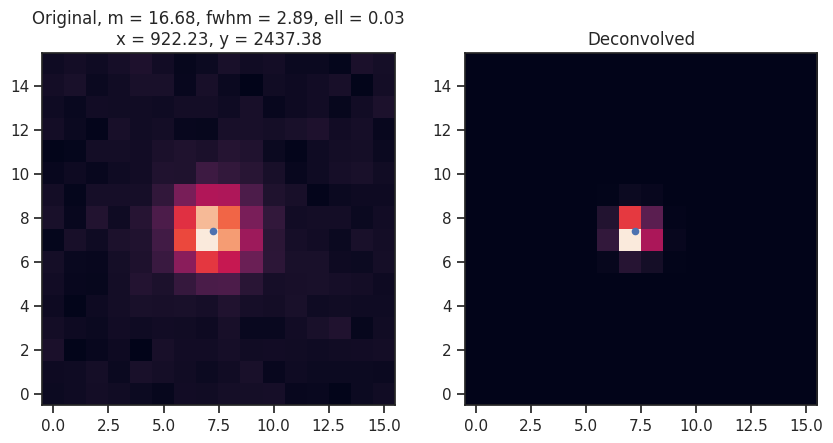

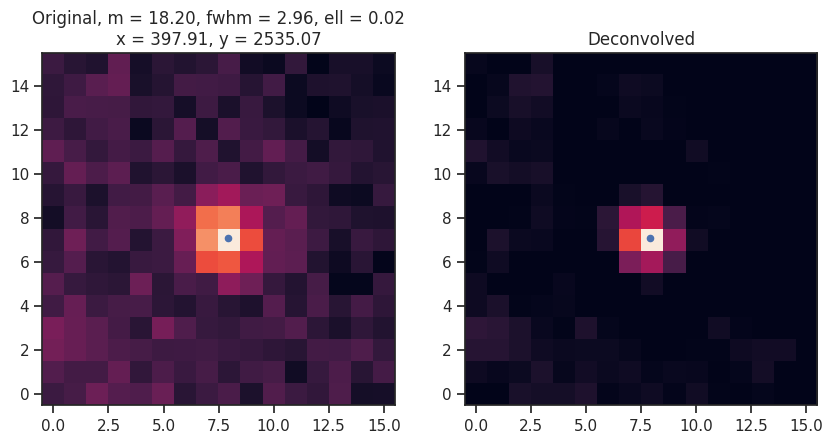

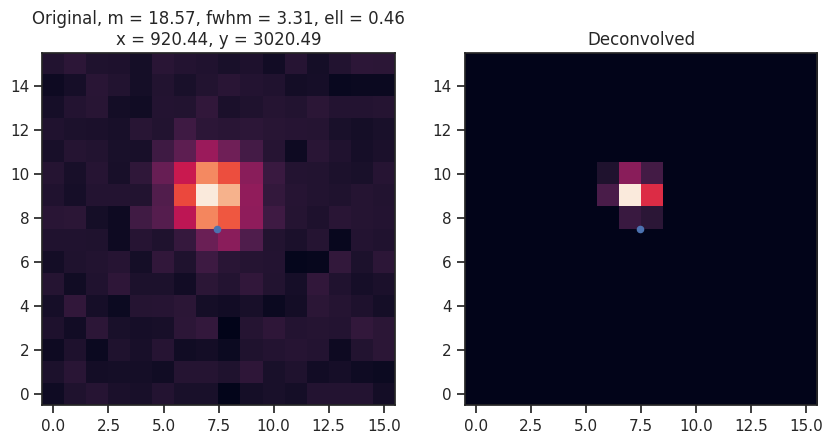

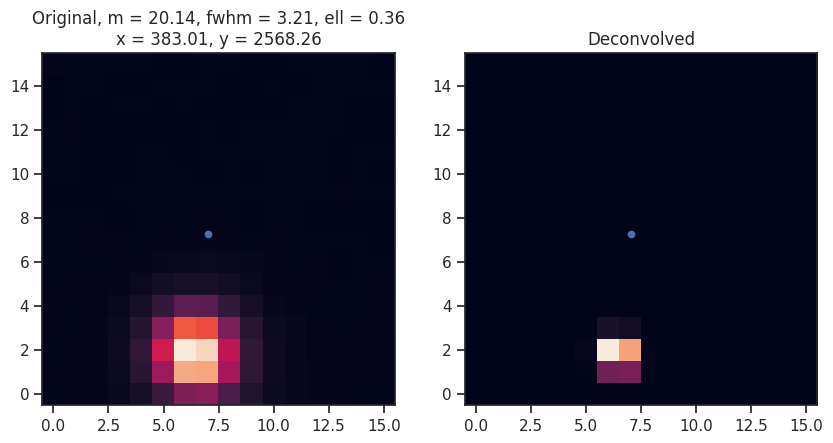

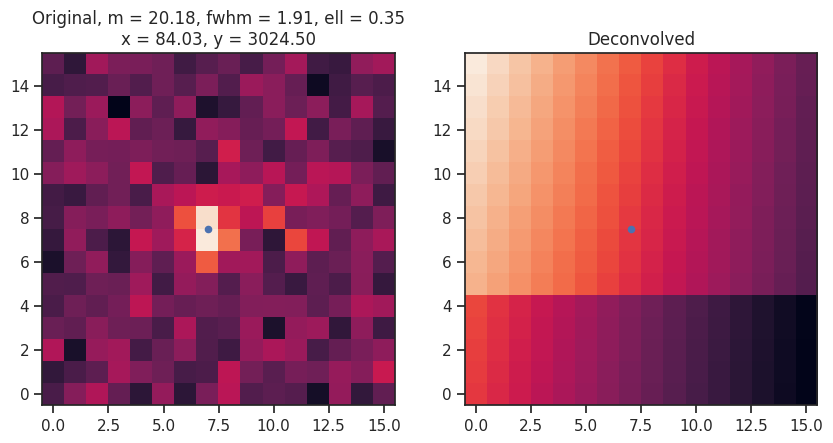

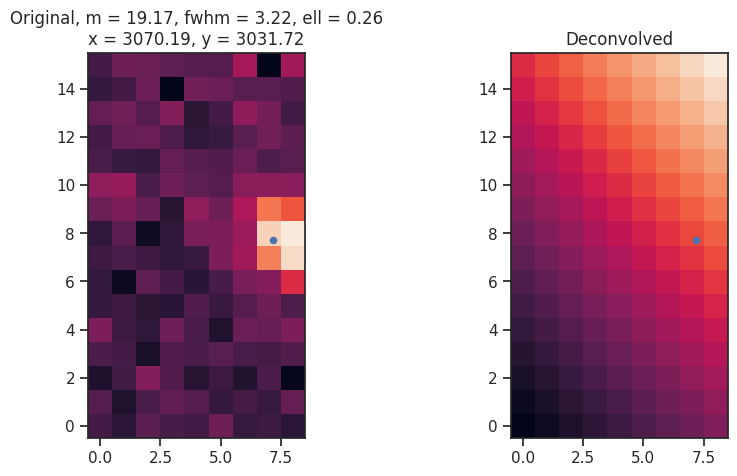

In [ ]:
data_path_sciimg = os.path.join(DIRNAME, IMAGE_FITS_NAMES[0])
hdul = fits.open(data_path_sciimg)
wcs = WCS(hdul[0].header)

def plot_unmatched_locations(unmatched_cat, name=None, fits_name=None):
    orig = fits.getdata(os.path.join(DIRNAME, fits_name[0]))
    deconv = fits.getdata(os.path.join(DIRNAME, fits_name[1]))

    # Debug mode: Allows to compare deconvolved and original sources individually.
    for row in unmatched_cat.iterrows():
        dcutout = Cutout2D(deconv, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=16)
        ocutout = Cutout2D(orig, (row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']), size=16, wcs=wcs)

        _x, _y = ocutout.to_cutout_position((row[1]['X_IMAGE_DBL'], row[1]['Y_IMAGE_DBL']))

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(ocutout.data, origin='lower')
        ax[0].set_title(f'Original, m = {row[1]["MAG_ISO"]:.2f}, fwhm = {row[1]["FWHM_IMAGE"]:.2f}, ell = {row[1]["ELLIPTICITY"]:.2f}\nx = {row[1]["X_IMAGE_DBL"]:.2f}, y = {row[1]["Y_IMAGE_DBL"]:.2f}')
        ax[1].imshow(dcutout.data, origin='lower')
        ax[1].set_title(f'Deconvolved')
        # Mark coordinates.
        ax[0].scatter([_x], [_y], s=20)
        ax[1].scatter([_x], [_y], s=20)

        if row[0] == 20:
            break

print('Same as above visualisation of sources, but only with plausible unmatched sources (after the three cuts above).')
plot_unmatched_locations(plausible_unmatches_low_ell, fits_name=IMAGE_FITS_NAMES)

TODO: In the above plot, add custom code to check for $\pm5$ pix region around the original source centroid to see if the deconvolved has a source there or not. This is not reliable but a first check. After that, mark that source in deconvolved with a X.

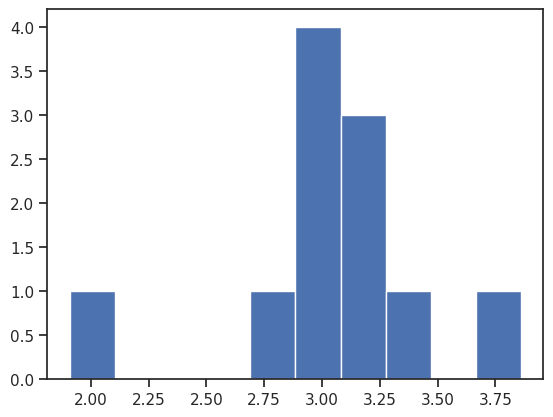

In [ ]:
plt.hist(plausible_unmatches_low_ell['FWHM_IMAGE']);

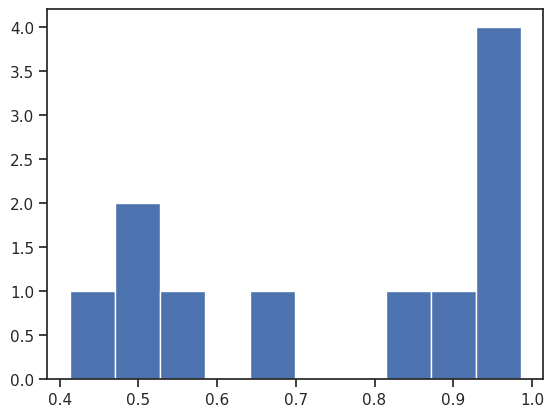

In [ ]:
plt.hist(plausible_unmatches_low_ell['CLASS_STAR']);

In [ ]:
plausible_unmatches_low_ell['FLAGS'].value_counts()

0.0     6
24.0    5
Name: FLAGS, dtype: int64

Now segregate the plausible unmatches based on the stellarity index, CLASS_STAR. One for CLASS_STAR > 0.5 and one for CLASS_STAR <= 0.5.

In [ ]:
plausible_unmatches1 = plausible_unmatches_low_ell[plausible_unmatches_low_ell['CLASS_STAR'] >= 0.5]
plausible_unmatches2 = plausible_unmatches_low_ell[plausible_unmatches_low_ell['CLASS_STAR'] < 0.5]
plausible_unmatches1.shape, plausible_unmatches2.shape

((8, 45), (3, 45))

This means more than half of the plausible unmatches are star-like.

### Two questions to explore

1. What is the faintest magnitude of the original source that is successfully retained in the deconvolved?
2. For the faint orig sources that were removed in the deconvolved, were these orig source present in a subdivision containing a saturated source? If so, that's expected.

First is explored in the next cell.

In [ ]:
mcat3['MAG_ISO_2'].nlargest(3), mcat2['MAG_ISO_2'].nlargest(3), mcat1['MAG_ISO_2'].nlargest(3)

(698    20.7464
 493    20.6544
 459    20.6478
 Name: MAG_ISO_2, dtype: float64,
 615    20.7464
 436    20.6544
 402    20.6478
 Name: MAG_ISO_2, dtype: float64,
 690    20.7464
 488    20.6544
 454    20.6478
 Name: MAG_ISO_2, dtype: float64)

Now, the second question.

In [ ]:
def check_sat_flag(x):
    """Checks whether the FLAG corresponding to a saturated pixel in the source is set or not."""
    x = int(x)
    return x & (1<<2)  # 2 means 3rd bit from the right, which corresponds to 2^2=4.

ocat_sat = ocat['FLAGS'].astype(int).apply(check_sat_flag)
ocat_sat.value_counts()

0    1471
Name: FLAGS, dtype: int64

In [ ]:
# # TODO: CODE REMAINING TO BE ADDED...
# orig_sat_sources = ocat['FLAGS']
# plausible_unmatches_low_ell['SUBDIV_NUMBER']

## Select (sufficiently bright) potential blended candidates

**THE DISCUSSION IN THIS SECTION DOES NOT HOLD IF THE SATURATED PIXELS ARE INTERPOLATED BEFORE DECONVOLUTION.**

1. Select those with sufficient offset between XPEAK_IMAGE and XWIN_IMAGE. XWIN_IMAGE is used instead of X_IMAGE since windowed centroids have more accuracy.
2. Then out of those, only select candidates that are sufficiently bright, e.g., with m < 15 or so.

In [ ]:
orig_cat = pd.read_csv('sgp_reconstruction_results/'+SOURCE_CATALOGS[0])

dist = np.abs(orig_cat['XPEAK_IMAGE'] - orig_cat['XWIN_IMAGE']) + np.abs(orig_cat['YPEAK_IMAGE'] - orig_cat['YWIN_IMAGE'])

orig_cat_filtered = orig_cat[dist > 2]
orig_cat_filtered_filtered = orig_cat_filtered[orig_cat_filtered['MAG_ISO'] < 15]
print(orig_cat_filtered_filtered.shape)
orig_cat_filtered_filtered

(24, 45)


,Unnamed: 0.1,Unnamed: 0,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,BACKGROUND,ISOAREA_IMAGE,ISOAREAF_IMAGE,...,AWIN_WORLD,BWIN_WORLD,THETAWIN_WORLD,MU_THRESHOLD,FLAGS,FWHM_IMAGE,ELONGATION,ELLIPTICITY,CLASS_STAR,SUBDIV_NUMBER
96,103,103,4.0,1846521.00,624.8726,10.4574,0.0004,607.9972,808.0,854.0,...,2.295418,2.234355,-80.89,22.6520,0.0,22.38,1.488,0.328,0.478,3.0
147,157,157,25.0,2568685.00,749.5106,10.0990,0.0003,610.6593,1239.0,1334.0,...,3.075226,2.679265,-64.27,22.6871,2.0,30.32,1.846,0.458,0.012,4.0
148,158,158,26.0,235513.80,214.0393,12.6933,0.0010,617.1948,52.0,71.0,...,1.822009,1.142582,85.14,23.0278,3.0,12.19,2.638,0.621,0.983,4.0
320,351,351,3.0,1974035.00,672.4296,10.3849,0.0004,611.4476,832.0,898.0,...,2.743239,2.406482,-83.22,22.5119,16.0,26.53,1.922,0.480,0.026,10.0
398,439,439,25.0,1677027.00,602.1516,10.5620,0.0004,610.3914,662.0,702.0,...,2.467796,2.123055,-86.20,22.5582,0.0,21.19,1.644,0.392,0.834,12.0
430,476,476,27.0,49547.04,191.5004,14.3858,0.0042,609.6193,218.0,233.0,...,1.946275,1.405444,-88.31,22.5505,24.0,11.91,1.518,0.341,0.043,13.0
496,547,547,32.0,1531549.00,565.7282,10.6605,0.0004,604.7629,702.0,749.0,...,2.381245,2.100010,80.05,22.7026,0.0,20.46,1.449,0.310,0.596,15.0
730,810,810,1.0,1322976.00,531.7120,10.8194,0.0004,607.1772,577.0,610.0,...,2.234462,1.950938,-85.58,22.5981,0.0,18.52,1.373,0.272,0.616,24.0
852,949,949,3.0,7704766.00,1402.0050,8.9064,0.0002,613.9655,2916.0,3282.0,...,14.616050,6.169801,-88.82,22.6971,24.0,104.66,11.127,0.910,0.028,28.0
1044,1164,1164,1.0,6695560.00,1372.7500,9.0588,0.0002,616.5864,2496.0,2817.0,...,11.832720,5.982895,87.53,22.7099,26.0,94.72,8.905,0.888,0.027,35.0


Although I wanted this to get blended candidates, it turns out many (or maybe even all) of them are actually clear saturated sources. Might be interesting to note this. Check the corresponding FLAGS.

In [ ]:
sat_count = 0
for row in orig_cat_filtered_filtered.iterrows():
    if int(row[1]['FLAGS']) & 4 != 0:  # Then the source has the bit corresponding to saturation set to 1. See https://sextractor.readthedocs.io/en/latest/Flagging.html
        sat_count += 1

print(f'Out of {orig_cat_filtered_filtered.shape[0]} rows in the filtered_filtered_original catalog, {sat_count} are saturated.')

Out of 24 rows in the filtered_filtered_original catalog, 0 are saturated.


## Selecting (sufficiently bright) potential blended candidates
### using crossmatching results

We want to select sources detected as single in original, but more than one in the deconvolved. Assuming the field is not crowded, most of the sources from the below criteria will yield us sufficiently bright, blended sources in the original image.

In other words, we want to select more than one source in the deconvolved matching with the same source in the original image. So we need `mcat3` but we should exclude rows also present in `mcat2_modified`.

In [ ]:
mcat3.shape, mcat2_modified.shape

((1477, 93), (862, 92))

In [ ]:
merged = mcat3.merge(mcat2_modified, how='left', indicator=True)
sources_in_mcat3_but_not_in_mcat2_modified = merged[merged['_merge'] == 'left_only']
sources_in_mcat3_but_not_in_mcat2_modified.shape

(615, 97)

Again, as done above in the notebook, an easier way is to use the `GroupID` column, as below.

See [this page](https://www.star.bris.ac.uk/~mbt/topcat/sun253/matchRowSelect.html) for more details.

In [ ]:
assert len(mcat3_groupid_sorted[~mcat3_groupid_sorted['GroupID'].isna()]) == len(sources_in_mcat3_but_not_in_mcat2_modified)

In [ ]:
sources_in_mcat3_but_not_in_mcat2_modified_groupID_sorted = sources_in_mcat3_but_not_in_mcat2_modified.sort_values(by='GroupID')
sources_in_mcat3_but_not_in_mcat2_modified_groupID_sorted.shape

(615, 97)

Now moving ahead...

In [ ]:
counter = 0

from scipy.spatial.distance import pdist

for row in sources_in_mcat3_but_not_in_mcat2_modified.itertuples():
    x, y = row.X_IMAGE_DBL_2, row.Y_IMAGE_DBL_2
    subset = sources_in_mcat3_but_not_in_mcat2_modified[(sources_in_mcat3_but_not_in_mcat2_modified['X_IMAGE_DBL_2'] == x) & (sources_in_mcat3_but_not_in_mcat2_modified['Y_IMAGE_DBL_2'] == y)]

    assert len(subset['GroupID'].unique()) == 1  # All rows of the subset must have the same GroupID, i.e., all rows must of the same match.
    _x = sources_in_mcat3_but_not_in_mcat2_modified_groupID_sorted[sources_in_mcat3_but_not_in_mcat2_modified_groupID_sorted['GroupID'] == subset['GroupID'].unique()[0]]
    assert _x.sort_values(by='col1_1').equals(subset.sort_values(by='col1_1'))
    assert len(subset) > 1

    ######## Below check is done over the deconvolved sources to remove near_duplicates. There wouldn't be exact duplicates, but near duplicates may likely correspond to a (spurious) scenario where an orig source was divided into more than one deconvolved sources.
    # This check is conservative since we don't want to remove any real cases where the two deconvolved sources were in fact very nearby.
    # Since the no. of deconvolved sources will generally only be 2-3, we perform a quick implementation to calculate pairwise distance between each row pair.
    _dist = pdist(subset[['X_IMAGE_DBL_1', 'Y_IMAGE_DBL_1']].values, metric='euclidean')  # Since we are using cartesian coordinates, we use the euclidean metric.
    if np.all(_dist < 5e-2):
        continue

    # Below, .iloc[0] or .iloc[n] where n is the no. of deconv sources this orig source has, any n will work since all rows will have the same orig magnitude.
    if subset['MAG_ISO_2'].iloc[0] <= 20.5 and subset['MAG_ISO_2'].iloc[0] >= 15:  # Magnitude cut.
        counter += 1

print(f'Out of {len(sources_in_mcat3_but_not_in_mcat2_modified)} original sources that had more than one deconvolved source based on the 1st selection, {counter} are true such cases after removing near duplicate deconvolved sources that are separated by much less than the crossmatching threshold.')

Out of 615 original sources that had more than one deconvolved source based on the 1st selection, 165 are true such cases after removing near duplicate deconvolved sources that are separated by much less than the crossmatching threshold.


From the above cell, it's clear that without the imposed criterion, multiple deconvolved sources for a given orig source could be in many cases, just a single source since those (apparently) multiple deconvolved sources are so close to each other (less than 1/20th of a pixel or a distance of 0.05) that it's hard to believe they are two different sources. There are 450 such sources (581-131), and hence are discarded.

**It's very important to note that this selection is only performed for this section, and the catalogs are not "refined" using this simple criterion.** Thus, one should only keep in mind that when you see 581 sources that have more than one counterpart in the deconvolved, it may not all be true cases due to the reasons mentioned above, and the actual number will be lesser than that. One primary reason why we have not modified the matched catalogs to remove such possible spurious cases is because some consideration is necessary while discarding. In particular, which deconvolved source to remove: the current one or the closest one? Now these deconvolved sources are very close to each other, so which source we remove will not significantly matter. But I feel it's better to keep the catalog as it is and simply perform these selection criteria for downstream purposes if required.

The left original source has 2 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([1008.8625, 1009.207], [224.4795, 224.7917])


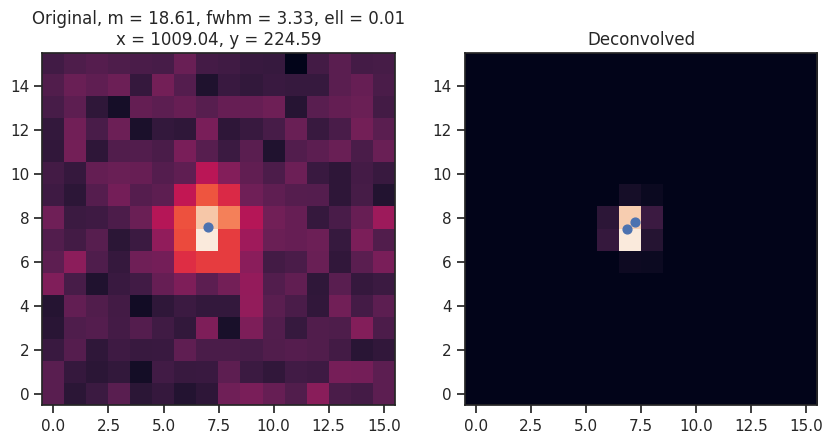

The left original source has 2 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([1008.8625, 1009.207], [224.4795, 224.7917])


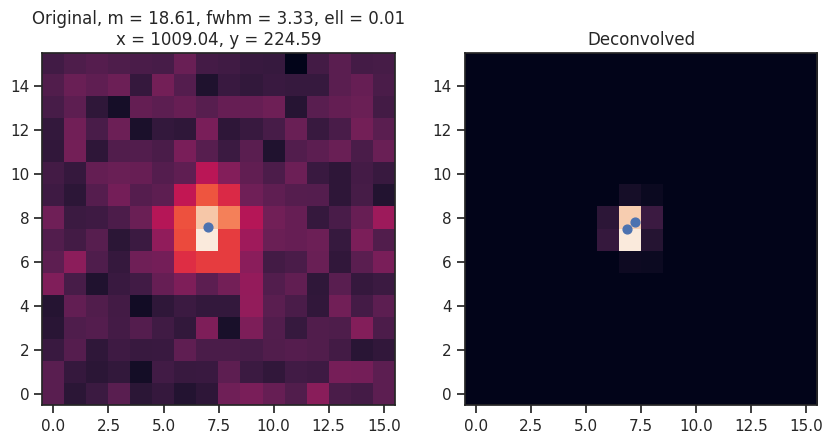

The left original source has 2 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([2618.0331, 2618.0524], [2.74, 2.5035])


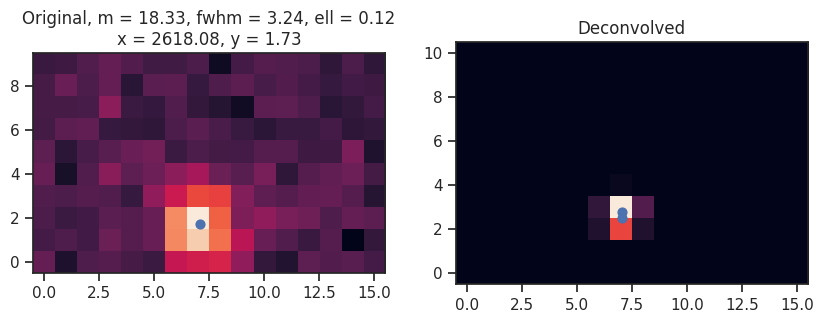

The left original source has 4 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([2620.8101, 2620.8245, 2620.8094, 2620.8287], [507.8506, 507.8025, 508.1222, 508.1198])


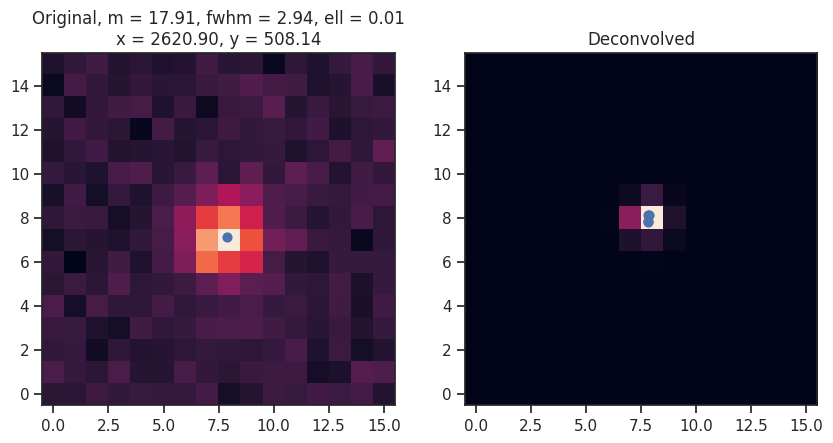

The left original source has 2 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([2850.1938, 2850.2892], [509.9546, 509.9738])


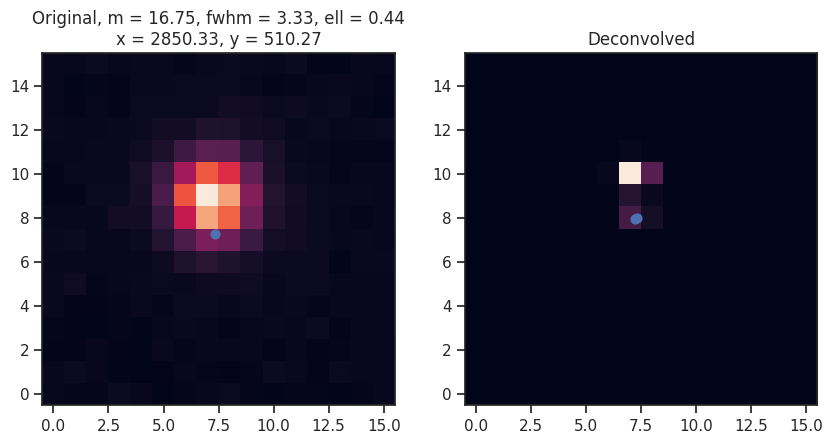

The left original source has 2 matched deconvolved sources.
x-coordinates and y-coordinates of the deconvolved sources: ([2810.3506, 2810.3291], [437.6062, 437.6582])


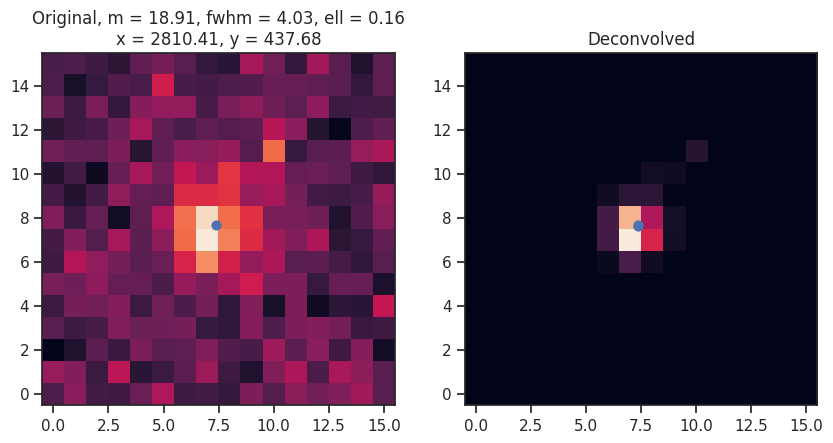

In [ ]:
data_path_sciimg = os.path.join(DIRNAME, IMAGE_FITS_NAMES[0])
hdul = fits.open(data_path_sciimg)
wcs = WCS(hdul[0].header)

orig = fits.getdata(os.path.join(DIRNAME, IMAGE_FITS_NAMES[0]))
deconv = fits.getdata(os.path.join(DIRNAME, IMAGE_FITS_NAMES[1]))

counter = 0
for row in sources_in_mcat3_but_not_in_mcat2_modified.itertuples():
    x, y = row.X_IMAGE_DBL_2, row.Y_IMAGE_DBL_2
    subset = sources_in_mcat3_but_not_in_mcat2_modified[(sources_in_mcat3_but_not_in_mcat2_modified['X_IMAGE_DBL_2'] == x) & (sources_in_mcat3_but_not_in_mcat2_modified['Y_IMAGE_DBL_2'] == y)]
    assert len(subset) > 1

    ######## Below check is done over the deconvolved sources to remove near_duplicates. There wouldn't be exact duplicates, but near duplicates may likely correspond to a (spurious) scenario where an orig source was divided into more than one deconvolved sources.
    # This check is conservative since we don't want to remove any real cases where the two deconvolved sources were in fact very nearby.
    # Since the no. of deconvolved sources will generally only be 2-3, we perform a quick implementation to calculate pairwise distance between each row pair.
    _dist = pdist(subset[['X_IMAGE_DBL_1', 'Y_IMAGE_DBL_1']].values, metric='euclidean')  # Since we are using cartesian coordinates, we use the euclidean metric.
    if np.all(_dist < 5e-2):
        continue

    # Below, .iloc[0] or .iloc[n] where n is the no. of deconv sources this orig source has, any n will work since all rows will have the same orig magnitude.
    if subset['MAG_ISO_2'].iloc[0] <= 20.5 and subset['MAG_ISO_2'].iloc[0] >= 15:  # Magnitude cut.
        if counter == 6:
            break
        # Below, .iloc[0] or .iloc[n] where n is the no. of deconv sources this orig source has, any n will work since all rows will have the same orig source.
        # For dcutout, we use the orig source centroids for simplicity.
        dcutout = Cutout2D(deconv, (subset['X_IMAGE_DBL_2'].iloc[0], subset['Y_IMAGE_DBL_1'].iloc[0]), size=16)
        ocutout = Cutout2D(orig, (subset['X_IMAGE_DBL_2'].iloc[0], subset['Y_IMAGE_DBL_2'].iloc[0]), size=16, wcs=wcs)

        # Below, .iloc[0] or .iloc[n] where n is the no. of deconv sources this orig source has, any n will work since all rows will have the same orig source.
        _x, _y = ocutout.to_cutout_position((subset['X_IMAGE_DBL_2'].iloc[0], subset['Y_IMAGE_DBL_2'].iloc[0]))
        # _xd and _yd will be more than one set of coordinates. These are used for marking the positions in the deconvolved cutout below.
        _xd, _yd = dcutout.to_cutout_position((subset['X_IMAGE_DBL_1'], subset['Y_IMAGE_DBL_1']))

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(ocutout.data, origin='lower')
        # Below, .iloc[0] or .iloc[n] where n is the no. of deconv sources this orig source has, any n will work since all rows will have the same orig source.
        ax[0].set_title(f'Original, m = {subset["MAG_ISO_2"].iloc[0]:.2f}, fwhm = {subset["FWHM_IMAGE_2"].iloc[0]:.2f}, ell = {subset["ELLIPTICITY_2"].iloc[0]:.2f}\nx = {subset["X_IMAGE_DBL_2"].iloc[0]:.2f}, y = {subset["Y_IMAGE_DBL_2"].iloc[0]:.2f}')
        ax[1].imshow(dcutout.data, origin='lower')
        ax[1].set_title(f'Deconvolved')
        # Mark coordinates.
        ax[0].scatter([_x], [_y], s=40)
        ax[1].scatter([_xd], [_yd], s=40)
        print(f'The left original source has {len(subset)} matched deconvolved sources.')
        print(f"x-coordinates and y-coordinates of the deconvolved sources: {(subset['X_IMAGE_DBL_1'].tolist(), subset['Y_IMAGE_DBL_1'].tolist())}")
        plt.show()

        counter += 1

## Small caveat

TODO: Need to update or decide whether to keep this section once crossmatching procedure is finalized.

In [ ]:
df = pd.read_csv(f'sgp_reconstruction_results/orig_{CROSSMATCH_PREFIX}_scat_sextractor.csv')
df1 = df.drop_duplicates(subset=['X_IMAGE_DBL', 'Y_IMAGE_DBL'], keep='first')
df.shape, df1.shape

((1471, 45), (1471, 45))

In [ ]:
df['MAG_ISO'].unique().shape, df['MAG_ISO'].shape

((1435,), (1471,))

In [ ]:
df1['MAG_ISO'].unique().shape, df1['MAG_ISO'].shape

((1435,), (1471,))

The caveat here is that while there are no repeat sources detected in the original catalog, the magnitudes, at least, are repeated since the no. of unique rows for magnitude does not match the total no. of rows. This can happen due to two reasons: (a) While moving from the cutout coordinates to the coordinates in the actual image, there were (very) small inaccuracies in the coordinates (much lesser than the typical crossmatching threshold, hopefully), due to which such rows were not removed in the `drop_duplicates()` step, both in `df1` here, and also with `df` in the `run.py` code. A solution to this is to instead use something like `drop_near_duplicates`, and (b) Indeed there were sources which were distinct but had the exact same magnitude - but it seems very unlikely that two different sources will have the same magnitude up to a few decimal precision.

If we don't want to use drop near duplicate approach, we may well disregard this caveat since there are only a very few such sources (1690 - 1653 = 37).

Also refer to the code comments in `scripts/run.py` for extensive documentation of this caveat.

## Analysis of astrometric improvements after deconvolution

TODO: NEED TO ADD ANALYSIS.